# **Legal Reasoning: Geometry-Aware Graph Injection with BoxE**

## 第一階段：全域配置與基礎設施模組化

In [ ]:
!pip install -q -U transformers peft datasets pyyaml accelerate bitsandbytes

In [ ]:
import os
import sys
import yaml
import torch
import numpy as np
import random
import json
from dataclasses import dataclass, asdict, field
from typing import Optional, Dict, Any
from google.colab import drive

In [ ]:
# ==========================================
# 1.0 基礎設施：環境偵測與路徑設定 (Environment-Aware Setup)
# ==========================================

def setup_environment(custom_path: str = None):
    """
    自動偵測執行環境 (Colab vs Local) 並設定對應的基礎路徑。

    Args:
        custom_path (str, optional): 強制指定的工作目錄路徑。若為 None，將自動決定。
            - Colab 預設: /content/drive/MyDrive/OSH_BoxE
            - Local 預設: ./OSH_BoxE (當前目錄下的 OSH_BoxE 資料夾)

    Returns:
        Tuple[str, str]: (base_path, output_dir)
    """
    # 1. 環境偵測
    try:
        from google.colab import drive
        is_colab = True
        print("偵測到 Google Colab 環境")
    except ImportError:
        is_colab = False
        print("偵測到 Local 本地環境")

    # 2. 決定 Base Path
    if custom_path:
        base_path = custom_path
    elif is_colab:
        drive.mount('/content/drive')
        base_path = "/content/drive/MyDrive/OSH_BoxE"
    else:
        # Local 模式：預設在當前目錄下
        base_path = os.path.join(os.getcwd(), "OSH_BoxE")

    # 3. 確保目錄存在
    if not os.path.exists(base_path):
        print(f"警告: 路徑 {base_path} 不存在，正在嘗試建立...")
        try:
            os.makedirs(base_path, exist_ok=True)
            print("   -> 建立成功")
        except Exception as e:
            print(f"   -> 建立失敗: {e}\n   請檢查權限或手動建立資料夾。")
    else:
        print(f"成功連接工作目錄: {base_path}")

    # 4. 設定 Output 子目錄
    output_dir = os.path.join(base_path, "experiment_outputs")
    os.makedirs(output_dir, exist_ok=True)

    return base_path, output_dir

In [ ]:
# ==========================================
# 1.2 種子鎖定 (Reproducibility Enforcement)
# ==========================================

def seed_everything(seed: int = 42):
    """
    嚴格鎖定所有隨機變數的種子，確保實驗可重現。
    包含 Python random, NumPy, PyTorch (CPU & GPU), 以及 CuDNN 的確定性行為。
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 若使用多 GPU

    # 確保卷積運算的確定性 (會稍微犧牲效能但保證結果一致)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"已鎖定全域隨機種子 (Global Seed): {seed}")

In [ ]:
# ==========================================
# 1.1 設定管理器 (Config Manager)
# ==========================================

@dataclass
class ModelParams:
    """LLM 與 Graph 的維度參數"""
    model_name: str = "Qwen/Qwen2.5-7B-Instruct"
    dim_llm: int = 4096  # Qwen2.5-7B 的 Hidden Size 通常為 4096
    dim_graph: int = 0   # 將從 embedding file 動態讀取
    max_seq_len: int = 2048
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

@dataclass
class TrainParams:
    """訓練與 LoRA 超參數"""
    seed: int = 42
    batch_size: int = 4
    learning_rate: float = 2e-4
    num_epochs: int = 3
    lora_rank: int = 64     # LoRA Rank
    lora_alpha: int = 128   # LoRA Alpha
    lora_dropout: float = 0.05
    gradient_accumulation_steps: int = 4

@dataclass
class PathParams:
    """檔案路徑管理 (由 ConfigManager 動態注入 base_dir)"""
    base_dir: str = ""    # 預設為空，初始化時填入
    output_dir: str = ""  # 預設為空，初始化時填入

    # 以下檔案名稱相對於 base_dir
    embedding_file: str = "final_embedding.pt"
    node_map_file: str = "node_to_idx.pt"
    rel_map_file: str = "rel_to_idx.pt"
    kg_json_file: str = "knowledge_graph_final.json"
    ground_truth_file: str = "_osh_legal_ground_truth_cleaned.json"
    sft_data_file: str = "sft_training_data_final.jsonl"

    def get_path(self, filename: str) -> str:
        """取得檔案的絕對路徑"""
        return os.path.join(self.base_dir, filename)

In [ ]:
class ConfigManager:
    """
    統一管理所有配置，並負責參數的儲存 (YAML) 與載入。
    """
    def __init__(self, custom_base_dir: str = None, seed: int = 42):
        # 1. 初始化環境與路徑
        self.base_dir, self.output_dir = setup_environment(custom_base_dir)

        # 2. 鎖定種子
        seed_everything(seed)

        # 3. 初始化參數模組
        self.paths = PathParams(base_dir=self.base_dir, output_dir=self.output_dir)
        self.model = ModelParams()
        self.train = TrainParams(seed=seed)

        # 4. 自動偵測 Graph Dimension
        self._detect_graph_dimension()

    def _detect_graph_dimension(self):
        """讀取 final_embedding.pt 來自動填入 dim_graph"""
        emb_path = self.paths.get_path(self.paths.embedding_file)
        try:
            print(f"正在偵測圖嵌入維度 ({emb_path})...")
            # 嘗試讀取 pytorch 檔案
            data = torch.load(emb_path, map_location='cpu', weights_only=False)

            # 假設結構中包含 'entity_embeddings'
            if isinstance(data, dict):
                if 'entity_embeddings' in data:
                    self.model.dim_graph = data['entity_embeddings'].shape[1]
                elif 'final_embedding' in data:
                     self.model.dim_graph = data['final_embedding'].shape[1]
                else:
                    print("提示: 無法直接從字典鍵值推斷維度，嘗試檢查第一個 Tensor 值...")
                    for k, v in data.items():
                        if isinstance(v, torch.Tensor) and len(v.shape) > 1:
                            self.model.dim_graph = v.shape[1]
                            print(f"從鍵值 '{k}' 偵測到維度。")
                            break
            elif isinstance(data, torch.Tensor):
                 self.model.dim_graph = data.shape[1]

            if self.model.dim_graph == 0:
                 print(f"警告: 無法自動偵測 dim_graph，預設設為 256")
                 self.model.dim_graph = 256
            else:
                print(f"成功偵測圖嵌入維度 (dim_graph): {self.model.dim_graph}")

        except FileNotFoundError:
            print(f"錯誤: 找不到嵌入檔案 {emb_path}。請確認路徑或將檔案放入該目錄。")
            self.model.dim_graph = 256 # Fallback for coding testing
        except Exception as e:
            print(f"讀取嵌入檔案時發生錯誤: {str(e)}")
            self.model.dim_graph = 256

    def save_config(self, filename: str = "config.yaml"):
        """將目前配置存檔"""
        config_dict = {
            "model": asdict(self.model),
            "train": asdict(self.train),
            "paths": asdict(self.paths)
        }

        save_path = os.path.join(self.paths.output_dir, filename)
        with open(save_path, 'w', encoding='utf-8') as f:
            yaml.dump(config_dict, f, default_flow_style=False, allow_unicode=True)
        print(f"配置已儲存至: {save_path}")

    def __repr__(self):
        return f"""
================ Configuration Summary ================
[Environment]
  Base Dir: {self.paths.base_dir}
  Output:   {self.paths.output_dir}

[Model]
  Name: {self.model.model_name}
  LLM Dim: {self.model.dim_llm}
  Graph Dim: {self.model.dim_graph}
  Device: {self.model.device}

[Training]
  Seed: {self.train.seed}
======================================================
"""

In [ ]:
# ==========================================
# 重新執行第一階段初始化 (Re-run Phase 1 Initialization)
# ==========================================

# 初始化管理器 (Initialize ConfigManager)
# 不傳入路徑 -> 自動偵測 (Colab=/content/drive..., Local=./OSH_BoxE)
# 若要指定 Local 特定路徑，可使用: ConfigManager(custom_base_dir="D:/MyProject/OSH")
config = ConfigManager(seed=42)

# 顯示配置 (Display Configuration)
print(config)

# 儲存配置檔供後續階段使用 (Save config for later stages)
config.save_config("phase1_config.yaml")

print("第一階段：全域配置與基礎設施模組化 - 完成")

成功連接工作目錄: /content/drive/MyDrive/OSH_BoxE
已鎖定全域隨機種子 (Global Seed): 42
成功偵測圖嵌入維度 (dim_graph): 128

================ Configuration Summary ================
[Model]
  Name: Qwen/Qwen2.5-7B-Instruct
  LLM Dim: 4096
  Graph Dim: 128
  Device: cuda

[Paths]
  Base: /content/drive/MyDrive/OSH_BoxE
  Output: /content/drive/MyDrive/OSH_BoxE/experiment_outputs
  Embedding: final_embedding.pt

[Training]
  Seed: 42
  Batch Size: 4
  LoRA Rank: 64

配置已儲存至: /content/drive/MyDrive/OSH_BoxE/experiment_outputs/phase1_config.yaml
第一階段：全域配置與基礎設施模組化 - 完成


Class ConfigManager 的必要性： 我們不使用全域變數 (Global Variables) 散落在 Notebook 各處，而是封裝在 ConfigManager 中。這符合軟體工程中的 Singleton Pattern 精神。當您進入第五階段「神經符號模型架構設計」時，您的 GraphProjector 類別只需要傳入 config.model.dim_graph，而不需要重新去 load pt 檔或猜測維度。

_detect_graph_dimension 的自動化： 您提供的 final_embedding (1).pt 是一個 Torch 的序列化檔案。為了避免手動輸入錯誤（例如 256 輸成 512），程式碼會嘗試自動讀取該檔案並偵測 Tensor 的第二維度（Feature Dimension）。這確保了後續 Linear(dim_graph, dim_inter) 層的 Input Dimension 絕對正確。

seed_everything 的深度鎖定： 在 PyTorch 中，單純設定 torch.manual_seed 是不夠的。對於 CUDA 操作，我們必須設定 deterministic = True。雖然這可能會讓訓練速度稍微變慢（因為禁用了某些 cuDNN 優化），但對於我們要證明「BoxE 邏輯帶來的準確率提升」而非「權重初始化的運氣」來說，這是必要的 trade-off。

檔案結構： 程式會自動在 OSH_BoxE 下建立 experiment_outputs 資料夾。所有的 log、checkpoint、config.yaml 都會存放在這裡，保持原始資料夾的整潔。

## 第二階段：幾何知識圖譜的張量解析 (Geometric KG Tensor Parsing)

程式碼設計重點：

KGMap 的雙向映射：為了極致的查詢速度，我們不使用 List 搜尋，而是建立兩個 Dictionary (id2text, text2id)。同時，我加入了 node_mapping 的自動偵測機制，因為根據 source ，您的 final_embedding.pt 中似乎已經包含了 node_mapping，這可以省去讀取額外檔案的工。

BoxE 的幾何還原：這部分最為棘手。標準 BoxE (Abboud et al.) 通常將 Entity 視為點 (Point)，Relation 視為盒 (Box)。但您的計畫（第六階段）需要計算「實體」之間的體積重疊。因此，我的 BoxEParser 會自動檢查 Embedding 的維度：

若 Embedding 維度是 dim_graph * 2，我會自動將其切分為 (center, width)，視為 Box。

若 Embedding 維度僅為 dim_graph（即 Entity 是點），我會提供一個 virtual_width 參數，將其「膨脹」為微小的超立方體，以便進行數學上的交集運算。

RGAT 鄰居預算 (Pre-computation)：這是訓練加速的關鍵。我們不能在 Training Loop 裡做 BFS。我設計了 NeighborhoodCacher，專門針對 INC_ 開頭的職災節點進行 1-hop/2-hop 索引快取。

In [ ]:
import torch
import json
import os
import re
from typing import Dict, List, Tuple, Union, Optional, Set
from collections import defaultdict
from tqdm.auto import tqdm

In [ ]:
# 引用第一階段的 Config (假設您已執行過第一階段)
try:
    print(f"Loading configuration from Phase 1...")
    # 這裡我們直接使用記憶體中的 config 物件，若 kernel 重啟過請重新執行 Phase 1
    config_phase2 = config
except NameError:
    # Fallback 如果使用者沒有在同一個 session 定義 config
    print("Warning: Config object not found. Please run Phase 1 first.")
    raise

Loading configuration from Phase 1...


In [ ]:
# ==========================================
# 2.1 實體與關係載入器 (Entity/Relation Loader)
# ==========================================

class KGMap:
    """
    負責實體(Entity)與關係(Relation)的 ID <-> Text 雙向映射。
    提供 O(1) 的查詢速度與名稱正規化。
    """
    def __init__(self, embedding_path: str, node_map_path: str = None):
        self.id2text: Dict[int, str] = {}
        self.text2id: Dict[str, int] = {}
        self.special_tokens = {"<UNK>": 0}

        self._load_mappings(embedding_path, node_map_path)

    def _load_mappings(self, embedding_path: str, node_map_path: str):
        print(f"正在載入 KG Mappings...")

        # 策略 1: 優先嘗試從 final_embedding.pt 中讀取 node_mapping (根據 source 1)
        loaded = False
        if os.path.exists(embedding_path):
            try:
                data = torch.load(embedding_path, map_location='cpu', weights_only=False)
                if isinstance(data, dict) and 'node_mapping' in data:
                    print(f"  -> 偵測到 final_embedding.pt 內含 node_mapping，正在讀取...")
                    raw_mapping = data['node_mapping']
                    # raw_mapping 可能是 {'name': id} 或其他格式，這裡做標準化
                    for name, idx in raw_mapping.items():
                        norm_name = self.normalize_name(name)
                        self.text2id[norm_name] = idx
                        self.id2text[idx] = norm_name
                    loaded = True
            except Exception as e:
                print(f"  -> 讀取 embedding 內 mapping 失敗: {e}")

        # 策略 2: 如果失敗，嘗試讀取獨立的 node_to_idx.pt
        if not loaded and node_map_path and os.path.exists(node_map_path):
            print(f"  -> 讀取外部檔案: {node_map_path}")
            raw_mapping = torch.load(node_map_path, map_location='cpu', weights_only=False)
            for name, idx in raw_mapping.items():
                norm_name = self.normalize_name(name)
                self.text2id[norm_name] = idx
                self.id2text[idx] = norm_name
            loaded = True

        if not loaded:
            print("  -> 警告: 未能載入任何 mapping，請檢查檔案路徑。將使用空字典。")
        else:
            print(f"  -> 成功載入 {len(self.id2text)} 個實體映射。")

    def normalize_name(self, name: str) -> str:
        """
        名稱正規化：
        1. 移除不必要的空白
        2. 處理特殊前綴 (如 source 1 中的 'CAUSE_BASIC_', 'INC_')
        """
        if not isinstance(name, str): return str(name)
        name = name.strip()
        # 這裡可以加入更多規則，例如統一大小寫
        return name

    def get_id(self, text: str) -> int:
        return self.text2id.get(self.normalize_name(text), self.special_tokens["<UNK>"])

    def get_text(self, idx: int) -> str:
        return self.id2text.get(idx, "<UNK>")

    @property
    def num_entities(self):
        return len(self.id2text)

In [ ]:
# ==========================================
# 2.2 BoxE 幾何邊界解構 (BoxE Boundary Parser)
# ==========================================

class BoxEParser:
    """
    將 Tensor 解析為幾何空間中的 Box。
    支援 'Center + Offset' 或 'Min + Max' 模式。
    """
    def __init__(self, embedding_path: str, device: str = "cpu"):
        self.device = device
        self.entity_centers = None
        self.entity_widths = None
        self.relation_centers = None
        self.relation_widths = None

        self._load_embeddings(embedding_path)

    def _load_embeddings(self, path: str):
        print(f"正在解析幾何嵌入 (Geometric Embeddings)...")
        if not os.path.exists(path):
            raise FileNotFoundError(f"找不到檔案: {path}")

        data = torch.load(path, map_location=self.device, weights_only=False) # weights_only=False 以支援 dict

        # 1. 解析 Entity Embeddings
        if 'entity_embeddings' in data:
            ent_emb = data['entity_embeddings']
            # 檢查維度：如果是 Box Embedding，通常維度是 dim * 2 (Center, Width)
            # 或者存在獨立的 entity_widths
            if 'entity_widths' in data:
                self.entity_centers = ent_emb
                self.entity_widths = data['entity_widths']
                print("  -> 實體幾何: 偵測到獨立的 Center 與 Width Tensor。")
            elif ent_emb.shape[1] % 2 == 0 and ent_emb.shape[1] > 2:
                # 假設是 [Center | Width] 的拼接
                mid = ent_emb.shape[1] // 2
                self.entity_centers = ent_emb[:, :mid]
                # 確保 width 為正數，通常使用 abs 或 softplus，這裡假設存儲時已處理或取 abs
                self.entity_widths = torch.abs(ent_emb[:, mid:])
                print(f"  -> 實體幾何: 偵測到拼接 Tensor，已切分為 Center/Width (Dim: {mid})。")
            else:
                # Fallback: 實體為點 (Point)，Width 設為微小值 (Virtual Box)
                self.entity_centers = ent_emb
                # 給予一個極小的寬度，讓點變成微小的 Box，以便進行體積交集運算
                self.entity_widths = torch.ones_like(ent_emb) * 1e-6
                print("  -> 實體幾何: 偵測到點嵌入 (Point Embeddings)，已轉換為 Virtual Box (width=1e-6)。")

        # 2. 解析 Relation Embeddings
        if 'relation_centers' in data and 'relation_widths' in data:
            self.relation_centers = data['relation_centers']
            self.relation_widths = data['relation_widths']
            print("  -> 關係幾何: 成功載入 Relation Centers 與 Widths。")

    def get_entity_box(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        取得指定 Entity ID 的幾何邊界。
        Returns:
            lower_bound (Tensor): Box 的下界
            upper_bound (Tensor): Box 的上界
        """
        if idx >= self.entity_centers.shape[0]:
            raise IndexError(f"Entity ID {idx} out of range.")

        center = self.entity_centers[idx]
        width = self.entity_widths[idx]

        # BoxE 定義: Center +/- Width (或者 Width 代表 Offset)
        # 這裡假設 Width 是從中心到邊界的距離 (半徑)
        lower_bound = center - width
        upper_bound = center + width
        return lower_bound, upper_bound

    def get_embedding_dim(self):
        return self.entity_centers.shape[1]

In [ ]:
# ==========================================
# 2.3 RGAT 鄰居聚合預處理 (Neighborhood Pre-computation)
# ==========================================

class NeighborhoodCacher:
    """
    預先計算圖結構的鄰居索引，避免在 Training Loop 中遍歷圖。
    專注於 'Incident' (職災) 節點的上下文提取。
    """
    def __init__(self, kg_json_path: str, kg_map: KGMap, max_hops: int = 2):
        self.adj_list = defaultdict(list)
        self.incident_cache = {} # Dict[int, List[int]]
        self.max_hops = max_hops
        self.kg_map = kg_map

        self._build_graph(kg_json_path)
        self._precompute_incidents()

    def _build_graph(self, json_path: str):
        print(f"正在建構圖結構 (Adjacency List)...")
        if not os.path.exists(json_path):
            print(f"警告: 找不到 KG JSON {json_path}，跳過圖建構。")
            return

        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            # 假設 JSON 格式是 List of triples 或類似 {'triples': [...]}
            # 這裡假設是常見的 list of [head, rel, tail]
            triples = data if isinstance(data, list) else data.get('triples', [])

            count = 0
            for item in tqdm(triples, desc="Parsing Triples"):
                # 根據實際 json 結構調整 keys
                h = item.get('head') or item.get('subject')
                t = item.get('tail') or item.get('object')

                h_id = self.kg_map.get_id(h)
                t_id = self.kg_map.get_id(t)

                # 建立無向或有向邊 (RGAT 通常視需求，這裡先建構無向以便聚合上下文)
                if h_id != 0 and t_id != 0:
                    self.adj_list[h_id].append(t_id)
                    self.adj_list[t_id].append(h_id)
                    count += 1
            print(f"  -> 圖建構完成: {len(self.adj_list)} 個節點, {count} 條邊。")

    def _precompute_incidents(self):
        """
        針對所有 'INC_' 開頭的節點進行 BFS 鄰居搜索
        """
        print(f"正在預算 {self.max_hops}-hop 鄰居索引...")

        # 找出所有 Incident Nodes
        incident_ids = []
        for text, idx in self.kg_map.text2id.items():
            if text.startswith("INC_") or text.startswith("VIO_"): # 根據 Source 1 的前綴
                incident_ids.append(idx)

        print(f"  -> 找到 {len(incident_ids)} 個目標節點 (INC/VIO)，開始 BFS...")

        for root_id in tqdm(incident_ids, desc="Pre-computing"):
            neighbors = self._bfs(root_id, self.max_hops)
            self.incident_cache[root_id] = neighbors

    def _bfs(self, start_node: int, hops: int) -> List[int]:
        visited = set([start_node])
        queue = [(start_node, 0)]
        results = []

        idx = 0
        while idx < len(queue):
            curr, depth = queue[idx]
            idx += 1

            if depth >= hops:
                continue

            for neighbor in self.adj_list[curr]:
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, depth + 1))
                    results.append(neighbor)

        # 可以在此限制鄰居數量 (例如 max 50) 以固定 Tensor 大小
        return results[:50] # Hard limit for tensor efficiency

    def get_neighbors(self, entity_id: int) -> List[int]:
        return self.incident_cache.get(entity_id, [])

In [ ]:
# ==========================================
# 執行第二階段：幾何知識圖譜張量解析
# ==========================================

# 1. 確保配置已載入
try:
    # 檢查是否已定義 config_phase2，若無則使用 Phase 1 的 config
    if 'config_phase2' not in locals() and 'config' in locals():
        config_phase2 = config
    elif 'config_phase2' not in locals():
        raise NameError("找不到配置物件 (config)。請先執行第一階段的 ConfigManager 初始化。")
except NameError as e:
    print(f"錯誤: {e}")
    # 停止執行後續代碼 (在 Notebook 中通常會報錯停止)
    raise

# 2. 定義路徑 (使用模組化的 get_path，自動適應 Local/Colab)
EMBEDDING_PATH = config_phase2.paths.get_path(config_phase2.paths.embedding_file)
KG_JSON_PATH = config_phase2.paths.get_path(config_phase2.paths.kg_json_file)
NODE_MAP_PATH = config_phase2.paths.get_path(config_phase2.paths.node_map_file)

print(f"[Phase 2] 路徑確認:")
print(f"   - Embedding: {EMBEDDING_PATH}")
print(f"   - KG JSON:   {KG_JSON_PATH}")
print(f"   - Node Map:  {NODE_MAP_PATH}")

# 3. 初始化組件
print("\n--- 初始化 KG Map ---")
kg_map = KGMap(embedding_path=EMBEDDING_PATH, node_map_path=NODE_MAP_PATH)

print("\n--- 初始化 BoxE Parser ---")
box_parser = BoxEParser(embedding_path=EMBEDDING_PATH, device=config_phase2.model.device)

--- 初始化 KG Map ---
正在載入 KG Mappings...
  -> 偵測到 final_embedding.pt 內含 node_mapping，正在讀取...
  -> 成功載入 2073 個實體映射。

--- 初始化 BoxE Parser ---
正在解析幾何嵌入 (Geometric Embeddings)...
  -> 實體幾何: 偵測到拼接 Tensor，已切分為 Center/Width (Dim: 64)。
  -> 關係幾何: 成功載入 Relation Centers 與 Widths。


In [ ]:
# 測試 BoxE 解析
if box_parser.entity_centers is not None:
    try:
        # 隨便抓一個 ID 測試 (例如 ID 10)
        test_id = 10
        lb, ub = box_parser.get_entity_box(test_id)
        print(f"  [Test] Entity {test_id} Box Lower Bound (前5維): {lb[:5].detach().cpu().numpy()}")
        print(f"  [Test] Entity {test_id} Box Upper Bound (前5維): {ub[:5].detach().cpu().numpy()}")
    except Exception as e:
        print(f"  [Test] BoxE 測試失敗: {e}")

print("\n--- 初始化 Neighborhood Cacher ---")
# 注意：若您的 json 很大，這步可能需要一點時間
neighborhood_cacher = NeighborhoodCacher(kg_json_path=KG_JSON_PATH, kg_map=kg_map, max_hops=2)

print("\n第二階段：幾何知識圖譜張量解析 - 完成")

  [Test] Entity 10 Box Lower Bound (前5維): [0. 0. 0. 0. 0.]
  [Test] Entity 10 Box Upper Bound (前5維): [0. 0. 0. 0. 0.]

--- 初始化 Neighborhood Cacher ---
正在建構圖結構 (Adjacency List)...


Parsing Triples: 0it [00:00, ?it/s]

  -> 圖建構完成: 0 個節點, 0 條邊。
正在預算 2-hop 鄰居索引...
  -> 找到 1025 個目標節點 (INC/VIO)，開始 BFS...


Pre-computing:   0%|          | 0/1025 [00:00<?, ?it/s]


第二階段：幾何知識圖譜張量解析 - 完成


In [ ]:
# 執行此區塊以自動偵測 JSON 結構並修復圖建構邏輯。

import json
from tqdm.auto import tqdm

def robust_build_graph(cacher_instance, json_path):
    """
    增強版的圖建構函數，能自動適應不同的 JSON 結構。
    """
    print(f"正在診斷 JSON 結構: {json_path}")

    with open(json_path, 'r', encoding='utf-8') as f:
        # 讀取部分內容進行診斷
        try:
            raw_data = json.load(f)
        except json.JSONDecodeError:
            print("錯誤: 無法解析 JSON 檔案。")
            return

    triples = []

    # 情況 A: 檔案本身就是一個 List
    if isinstance(raw_data, list):
        print("  -> 偵測到 JSON Root 為 List。")
        triples = raw_data
    # 情況 B: 檔案是 Dict，需要找 Key
    elif isinstance(raw_data, dict):
        print(f"  -> 偵測到 JSON Root 為 Dict，Keys: {list(raw_data.keys())}")
        # 常見的 Key 名稱嘗試
        for key in ['triples', 'edges', 'facts', 'data', 'links']:
            if key in raw_data:
                print(f"  -> 成功匹配 Key: '{key}'")
                triples = raw_data[key]
                break
        if not triples:
            print("  -> 警告: 無法找到常見的三元組 Key，嘗試使用第一個 Value...")
            first_val = next(iter(raw_data.values()))
            if isinstance(first_val, list):
                triples = first_val

    if not triples:
        print("錯誤: 無法提取三元組，請手動檢查檔案結構。")
        return

    print(f"  -> 提取到 {len(triples)} 個三元組，範例: {triples[0]}")

    # 重新建構 adj_list
    cacher_instance.adj_list.clear()
    count = 0

    # 自動偵測三元組內的 Key (head/tail, sub/obj, source/target, h/t)
    sample = triples[0]
    h_key, t_key = None, None

    # 優先順序配對
    possible_pairs = [
        ('head', 'tail'), ('subject', 'object'),
        ('source', 'target'), ('h', 't'),
        ('src', 'dst'), ('head_entity', 'tail_entity')
    ]

    for h, t in possible_pairs:
        if h in sample and t in sample:
            h_key, t_key = h, t
            break

    if not h_key:
        print(f"錯誤: 無法識別三元組內的欄位名稱。範例 keys: {list(sample.keys())}")
        return

    print(f"  -> 使用欄位映射: Head='{h_key}', Tail='{t_key}'")

    for item in tqdm(triples, desc="Re-building Graph"):
        h_text = item.get(h_key)
        t_text = item.get(t_key)

        # 轉換為 ID
        h_id = cacher_instance.kg_map.get_id(h_text)
        t_id = cacher_instance.kg_map.get_id(t_text)

        # 過濾掉 UNK (0)
        if h_id != 0 and t_id != 0:
            cacher_instance.adj_list[h_id].append(t_id)
            cacher_instance.adj_list[t_id].append(h_id)
            count += 1

    print(f"  -> 修復完成: {len(cacher_instance.adj_list)} 個節點, {count} 條有效邊。")

    # 重新計算鄰居
    cacher_instance._precompute_incidents()

# 執行修復
if 'neighborhood_cacher' in locals():
    robust_build_graph(neighborhood_cacher, config_phase2.paths.get_path("knowledge_graph_final.json"))
else:
    print("請先執行 Phase 2 的原始代碼區塊以初始化 neighborhood_cacher。")

正在診斷 JSON 結構: /content/drive/MyDrive/OSH_BoxE/knowledge_graph_final.json
  -> 偵測到 JSON Root 為 Dict，Keys: ['directed', 'multigraph', 'graph', 'nodes', 'links']
  -> 成功匹配 Key: 'links'
  -> 提取到 50197 個三元組，範例: {'source': 'INC_4becb25cffa5', 'target': 'MED_SPECIFIC_ffd238a5cd77', 'relation': 'INVOLVES_OBJECT', 'confidence': 1.0, 'redistribution_method': 'unchanged'}
  -> 使用欄位映射: Head='source', Tail='target'


Re-building Graph:   0%|          | 0/50197 [00:00<?, ?it/s]

  -> 修復完成: 2059 個節點, 50194 條有效邊。
正在預算 2-hop 鄰居索引...
  -> 找到 1025 個目標節點 (INC/VIO)，開始 BFS...


Pre-computing:   0%|          | 0/1025 [00:00<?, ?it/s]

針對您專案的深度思考 (Reflection on Implementation):
為什麼 KGMap 需要偵測內部 node_mapping？ 根據您的 Source 1 (final_embedding (1).pt)，這個檔案實際上是一個包含了多個鍵值的 Dictionary (Pickle 格式)，其中直接包含了 node_mapping。這在實務上很常見，可以避免 node_to_idx.pt 版本與 embedding 版本不一致的問題（例如重新訓練後 ID shift）。我的代碼優先信任 embedding 檔案內的 mapping，這是確保 Alignment (對齊) 正確的關鍵。

BoxE 的 Virtual Box 處理策略： 您的 Source 1 顯示有 entity_embeddings 和 relation_widths 。這暗示該模型可能是標準 BoxE（實體是點，關係是盒）。然而，您的第六階段要求計算 Box(Incident) \cap Box(Law)。

這是一個邏輯上的 Gap。如果實體原本是點，它們沒有體積，交集永遠為零。

解決方案：我在 BoxEParser 中實作了 Fallback 機制。如果偵測到實體是點（維度沒有 x2），我會給予它一個極小的 width (1e-6)。這讓「點」在數學上變成一個極小的「方塊」，使得包含運算 (Subsumption) 依然可以執行（判斷點是否在另一個 Box 內），同時保持了程式碼對不同 BoxE 變體的兼容性。

RGAT 鄰居的 Hard Limit： 在 _bfs 方法的最後，我加上了 return results[:50]。這是一個針對 GPU 訓練的工程優化。如果不限制鄰居數量，某些「超級節點」（Super Nodes，如常見的法規類別）可能會連接數千個節點，導致 RGAT 在聚合時 OOM (Out of Memory) 或 Padding 過長影響效能。對於職災推理，取最近的 50 個鄰居通常已包含足夠的上下文資訊。

## 第三階段：法律與職災數據工程 (Legal & Incident Data Engineering)

3.1 黃金標準解析 (Ground Truth Parsing)：

清洗 _osh_legal_ground_truth_cleaned.json。

關鍵細節：將每個 Case 的 "Correct Law" 轉換為 KG 中的 Entity ID。如果找不到對應 ID，需記錄為 UNK 並在分析報告中剔除或標記，避免非戰之罪。

3.2 SFT 數據格式化 (Instruction Formatting)：

處理 sft_training_data_test.jsonl。

設計特殊的 ChatTemplate，在 system prompt 與 user prompt 之間預留 <GRAPH_Info> 的插入點。

In [ ]:
# 執行此區塊以自動從 KG 檔案建立法規對齊表，並解析 Ground Truth。

import json
import re
import os
from tqdm.auto import tqdm
from typing import Dict, Set, List, Optional

In [ ]:
# ==========================================
# 3.0 動態對齊映射器 (Dynamic Alignment Mapper)
# ==========================================

class DynamicAlignmentMapper:
    """
    專門解決 '中文法規名稱' 與 'KG Hash ID' 之間的對齊問題。
    自動掃描 knowledge_graph_final.json 建立映射表。
    """
    def __init__(self, kg_json_path: str):
        self.text_to_hash: Dict[str, str] = {}
        self.hash_to_text: Dict[str, str] = {}
        self._build_mapping(kg_json_path)

    def _normalize(self, text: str) -> str:
        """標準化中文法規名稱，移除空白與全形字元干擾"""
        if not isinstance(text, str): return str(text)
        # 移除空格、全形空格
        text = text.replace(" ", "").replace("　", "")
        # 移除常見標點 (視情況調整)
        text = text.replace("。", "").replace("，", "")
        return text

    def _build_mapping(self, path: str):
        print(f"正在建立法規對齊表 (Scanning KG): {path}")
        if not os.path.exists(path):
            print(f"錯誤: 找不到 KG 檔案 {path}")
            return

        with open(path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
            except:
                print("錯誤: KG JSON 解析失敗")
                return

        count = 0

        # 策略 A: 檢查是否有 'nodes' 列表 (常見 Graph JSON 格式)
        nodes = []
        if isinstance(data, dict):
            if 'nodes' in data:
                nodes = data['nodes']
            elif 'entities' in data:
                nodes = data['entities']
        elif isinstance(data, list):
            # 如果是 list，有可能每個元素就是一個 node dict，或者混合了 triples
            # 我們假設若有 'name' 屬性則為 node
            nodes = [item for item in data if 'name' in item and 'id' in item]

        # 掃描節點
        for node in tqdm(nodes, desc="Mapping Entities"):
            node_id = node.get('id')
            node_name = node.get('name') or node.get('label') or node.get('text')

            # 只處理法規節點 (通常是 REG_ 開頭)
            if node_id and node_name and isinstance(node_id, str):
                if node_id.startswith("REG_") or node_id.startswith("VIO_"):
                    norm_name = self._normalize(node_name)
                    self.text_to_hash[norm_name] = node_id
                    self.hash_to_text[node_id] = node_name
                    count += 1

        # 策略 B: 如果找不到 nodes，嘗試從 triples 中尋找 (Hash -> has_name -> "中文")
        if count == 0 and isinstance(data, dict) and 'triples' in data:
            print("  -> 嘗試從 Triples 推斷名稱關係...")
            for trip in data['triples']:
                # 假設關係類型是 "has_name", "label", "alias" 等
                rel = trip.get('relation') or trip.get('type')
                if rel in ['has_name', 'name', 'label']:
                    head = trip.get('head')
                    tail = trip.get('tail') # 假設 tail 是中文名稱
                    if head and tail and head.startswith("REG_"):
                        norm_name = self._normalize(tail)
                        self.text_to_hash[norm_name] = head
                        self.hash_to_text[head] = tail
                        count += 1

        print(f"  -> 對齊表建立完成: 找到 {count} 個法規映射關係。")
        if count > 0:
            sample_key = next(iter(self.text_to_hash))
            print(f"  -> 範例: '{sample_key}' -> '{self.text_to_hash[sample_key]}'")
        else:
            print("  -> 警告: 未能建立任何映射，請確認 knowledge_graph_final.json 結構。")

    def get_hash(self, text: str) -> Optional[str]:
        return self.text_to_hash.get(self._normalize(text))

In [ ]:
import torch
from torch.utils.data import Dataset
import json
import os

class OmniGraphSFTDataset(Dataset):
    def __init__(self, data_path, tokenizer, node_to_idx_path, max_seq_length=1024):
        self.data = []
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

        # --- 1. 解決路徑問題 (Path Resolution) ---
        # 修改：移除 Colab 特定的硬編碼路徑，改為信任傳入的參數
        if not os.path.exists(node_to_idx_path):
            # 僅嘗試當前目錄作為最後手段
            fallback_path = "node_to_idx.pt"
            if os.path.exists(fallback_path):
                print(f"警告: 指定路徑 {node_to_idx_path} 不存在，自動降級使用當前目錄: {fallback_path}")
                node_to_idx_path = fallback_path
            else:
                raise FileNotFoundError(f"找不到 node_to_idx.pt，請檢查路徑參數: {node_to_idx_path}")

        self.node_to_idx = torch.load(node_to_idx_path)
        print(f"Node Map 載入完成，共有 {len(self.node_to_idx)} 個節點。")

        # --- 2. 智慧載入與格式解析 (Smart Parsing) ---
        print(f"正在解析數據檔案: {data_path}")

        valid_count = 0
        null_id_count = 0

        with open(data_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f):
                try:
                    item = json.loads(line)
                    incident_id = None
                    instruction = ""
                    input_text = ""
                    output_text = ""

                    # === 策略 A: 原始 SFT 格式 (建議使用) ===
                    if 'incident_id' in item:
                        incident_id = item['incident_id']
                        instruction = item.get('instruction', '')
                        input_text = item.get('input', '')
                        output_text = item.get('output', '')

                    # === 策略 B: 您提供的 Formatted 格式 (巢狀 metadata) ===
                    elif 'metadata' in item:
                        meta = item['metadata']
                        # 嘗試從 metadata 找 ID
                        incident_id = meta.get('incident_id') or meta.get('id')

                        # 解析 text 欄位回推 instruction/input (這很痛苦且易錯，僅作 fallback)
                        # 如果 text 已經包含了 <|im_start|> 等 tag，我們稍後直接拿來用
                        if 'text' in item:
                            raw_text = item['text']
                            # 這裡假設 formatted data 已經處理好 prompt
                            input_text = raw_text
                            output_text = "" # Formatted data 通常已經混合了 input/output

                    # === 3. 關鍵診斷 ===
                    if incident_id is None:
                        null_id_count += 1
                        if null_id_count <= 3:
                            print(f"[警告 Line {line_num}] ID 為 None (Metadata: {item.get('metadata')})")
                        continue

                    # === 4. 圖譜對齊 (Graph Alignment) ===
                    if incident_id in self.node_to_idx:
                        # 成功連結！
                        entry = {
                            "graph_idx": self.node_to_idx[incident_id],
                            "raw_item": item,
                            "use_preformatted_text": 'text' in item and 'metadata' in item
                        }
                        self.data.append(entry)
                        valid_count += 1
                    else:
                        # ID 存在但不在圖譜中
                        pass

                except json.JSONDecodeError:
                    continue

        print(f"\n數據集統計:")
        print(f"   - 總行數: {line_num + 1}")
        print(f"   - ID 為 Null 被丟棄: {null_id_count} (如果是 formatted data，這很致命)")
        print(f

In [ ]:
# ==========================================
# 3.1 黃金標準解析 (Ground Truth Parsing)
# ==========================================

class GroundTruthLoader:
    def __init__(self, file_path: str, kg_map: KGMap, aligner: DynamicAlignmentMapper):
        self.kg_map = kg_map
        self.aligner = aligner
        self.ground_truth = {}
        self.unk_stats = 0
        self.total_laws = 0

        self._load_data(file_path)

    def _load_data(self, path: str):
        print(f"\n正在解析 Ground Truth (Target: ground_truth_fine): {path}")
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        for entry in tqdm(data, desc="Parsing GT"):
            case_id = entry.get('id') or entry.get('case_id')

            # 優先使用細粒度法規
            laws = entry.get('ground_truth_fine', [])
            if not laws:
                laws = entry.get('ground_truth_coarse', [])
                if not laws:
                    laws = entry.get('correct_laws', [])

            law_ids = set()
            for law_text in laws:
                self.total_laws += 1

                # 步驟 1: 嘗試透過 Aligner 將 "中文" 轉為 "REG_Hash"
                kg_hash_id = self.aligner.get_hash(law_text)

                # 步驟 2: 將 "REG_Hash" (或原始文字) 轉為 Integer ID
                entity_id = 0
                if kg_hash_id:
                    # 找到了 Hash ID
                    entity_id = self.kg_map.get_id(kg_hash_id)
                else:
                    # 沒找到 Hash，嘗試直接用中文查 (防止 KG 本身就是存中文)
                    entity_id = self.kg_map.get_id(self.aligner._normalize(law_text))

                if entity_id == 0:
                    self.unk_stats += 1
                    # Debug: 只印前幾個錯誤
                    if self.unk_stats <= 3:
                        print(f"  [MISS] '{law_text}' 無法對齊到任何 Entity ID (Hash Found: {kg_hash_id})")
                else:
                    law_ids.add(entity_id)

            if case_id:
                self.ground_truth[str(case_id)] = law_ids

        unk_rate = self.unk_stats / max(1, self.total_laws)
        print(f"  -> 解析完成: {len(self.ground_truth)} 個案例。")
        print(f"  -> 匹配統計: Total={self.total_laws}, Mismatched={self.unk_stats} ({unk_rate:.1%})")

In [ ]:
# ==========================================
# 執行 第三階段：數據工程
# ==========================================

# 1. 定義路徑 (動態獲取)
KG_JSON_PATH = config_phase2.paths.get_path(config_phase2.paths.kg_json_file)
GT_PATH = config_phase2.paths.get_path(config_phase2.paths.ground_truth_file)
SFT_INPUT_PATH = config_phase2.paths.get_path(config_phase2.paths.sft_data_file)
SFT_OUTPUT_PATH = os.path.join(config_phase2.paths.output_dir, "sft_training_data_final.jsonl")

print(f"📂 [Phase 3] 路徑確認:")
print(f"   - KG JSON: {KG_JSON_PATH}")
print(f"   - Ground Truth: {GT_PATH}")

# 2. 建立對齊映射 (這是關鍵!)
print("\n--- 3.0 建立動態對齊表 ---")
alignment_mapper = DynamicAlignmentMapper(KG_JSON_PATH)

# 3. 解析 Ground Truth
print("\n--- 3.1 解析 Ground Truth ---")
if 'kg_map' in locals():
    gt_loader = GroundTruthLoader(GT_PATH, kg_map, alignment_mapper)
else:
    print("警告: 缺少 kg_map (Phase 2產物)，請先執行 Phase 2。")

--- 3.0 建立動態對齊表 ---
正在建立法規對齊表 (Scanning KG): /content/drive/MyDrive/OSH_BoxE/knowledge_graph_final.json


Mapping Entities:   0%|          | 0/2073 [00:00<?, ?it/s]

  -> 對齊表建立完成: 找到 1032 個法規映射關係。
  -> 範例: '勞工未架設安全通道與踏板' -> 'VIO_c8063dd2c3be'

--- 3.1 解析 Ground Truth ---

正在解析 Ground Truth (Target: ground_truth_fine): /content/drive/MyDrive/OSH_BoxE/_osh_legal_ground_truth_cleaned.json


Parsing GT:   0%|          | 0/381 [00:00<?, ?it/s]

  [MISS] '職業安全衛生設施規則第120條' 無法對齊到任何 Entity ID (Hash Found: None)
  [MISS] '條暨職業安全衛生法第6條第1項' 無法對齊到任何 Entity ID (Hash Found: None)
  [MISS] '職業安全衛生設施規則第230條' 無法對齊到任何 Entity ID (Hash Found: None)
  -> 解析完成: 381 個案例。
  -> 匹配統計: Total=3084, Mismatched=55 (1.8%)


## 第四階段：強基線檢索系統 (Robust RAG Baseline Implementation)

我們將使用 BM25（針對關鍵字精確匹配，如「乙炔」、「施工架」）與 BGE-M3（針對語意理解，目前開源界最強的中文 Embedding 之一）進行混合檢索。此外，針對職業安全衛生的領域特性，我們加入規則式的 重排序 (Reranking) 機制。

4.1 混合檢索器 (Hybrid Retriever)：

Sparse: 使用 jieba 分詞 + BM25 (針對法條關鍵字，如「高處」、「缺氧」)。

Dense: 使用 BGE-M3 或 OpenAI-Embedding 針對法條語意。

4.2 法律專用重排序 (Legal Reranking)：

考慮加入簡單的 Rule-based filter (例如：若發生在「營造業」，優先權重提升「營造安全衛生設施標準」)。

In [ ]:
!pip install rank_bm25

In [ ]:
import os
import jieba
import numpy as np
import torch
from typing import List, Dict, Tuple, Union
from tqdm.auto import tqdm
from rank_bm25 import BM25Okapi

In [ ]:
# 自動安裝必要的 RAG 套件
try:
    import faiss
    from sentence_transformers import SentenceTransformer
except ImportError:
    print("正在安裝 RAG 必要套件 (rank_bm25, sentence-transformers, faiss-cpu)...")
    os.system('pip install -q rank_bm25 sentence-transformers faiss-cpu')
    import faiss
    from sentence_transformers import SentenceTransformer

In [ ]:
# ==========================================
# 4.0 法律語料庫構建 (Legal Corpus Builder)
# ==========================================

class LegalCorpus:
    """
    從 Phase 3 建立的對齊表 (DynamicAlignmentMapper) 中提取所有法規文本。
    這是 RAG 的搜尋範圍 (Search Space)。
    """
    def __init__(self, mapper: 'DynamicAlignmentMapper', kg_map: 'KGMap'):
        self.documents: List[str] = []      # 法規全文列表
        self.doc_ids: List[int] = []        # 對應的 KG Entity ID
        self.doc_hashes: List[str] = []     # 對應的 KG Hash string

        self._build_corpus(mapper, kg_map)

    def _build_corpus(self, mapper, kg_map):
        print("正在構建法律語料庫 (Legal Corpus)...")
        # 來源：Phase 3 的 text_to_hash 對照表
        # key: 中文法規名稱, value: REG_Hash
        unique_docs = set()

        for text, hash_id in tqdm(mapper.text_to_hash.items(), desc="Indexing Laws"):
            if text not in unique_docs:
                # 取得 Integer ID
                entity_id = kg_map.get_id(hash_id)
                if entity_id != 0:
                    self.documents.append(text)
                    self.doc_ids.append(entity_id)
                    self.doc_hashes.append(hash_id)
                    unique_docs.add(text)

        print(f"  -> 語料庫構建完成: 共 {len(self.documents)} 條法規可供檢索。")

In [ ]:
# ==========================================
# 4.1 混合檢索器 (Hybrid Retriever)
# ==========================================

class HybridRetriever:
    """
    結合 Sparse (BM25) 與 Dense (BGE-M3) 的檢索器。
    """
    def __init__(self, corpus: LegalCorpus, device: str = None):
        self.corpus = corpus
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")

        # 1. Sparse Retriever (BM25)
        self.bm25 = self._build_bm25()

        # 2. Dense Retriever (BGE-M3)
        # 使用 BAAI/bge-m3，這是目前支援多語言與長文本表現極佳的模型
        print(f"正在載入 Dense Model (BAAI/bge-m3) 到 {self.device}...")
        self.embedding_model = SentenceTransformer('BAAI/bge-m3', device=self.device)
        self.dense_index = self._build_dense_index()

    def _build_bm25(self):
        print("  -> 建立 BM25 索引 (jieba 分詞)...")
        tokenized_corpus = [list(jieba.cut(doc)) for doc in self.corpus.documents]
        return BM25Okapi(tokenized_corpus)

    def _build_dense_index(self):
        print("  -> 建立 Dense 向量索引 (FAISS)...")
        # Encode
        embeddings = self.embedding_model.encode(
            self.corpus.documents,
            batch_size=32,
            show_progress_bar=True,
            normalize_embeddings=True
        )

        # Build FAISS Index (Inner Product for Cosine Similarity since normalized)
        dim = embeddings.shape[1]
        index = faiss.IndexFlatIP(dim)
        index.add(embeddings)
        return index

    def search(self, query: str, top_k: int = 20, alpha: float = 0.5) -> List[Dict]:
        """
        執行混合檢索。
        alpha: 權重參數 (0.0 = 純 BM25, 1.0 = 純 Dense)
        """
        # 1. Sparse Search
        tokenized_query = list(jieba.cut(query))
        bm25_scores = self.bm25.get_scores(tokenized_query)

        # 正規化 BM25 分數 (Min-Max Scaling) 以便與 Cosine Similarity 混合
        if len(bm25_scores) > 0:
            min_score = np.min(bm25_scores)
            max_score = np.max(bm25_scores)
            if max_score > min_score:
                bm25_scores = (bm25_scores - min_score) / (max_score - min_score)
            else:
                bm25_scores = np.zeros_like(bm25_scores)

        # 2. Dense Search
        query_embedding = self.embedding_model.encode([query], normalize_embeddings=True)
        dense_scores, _ = self.dense_index.search(query_embedding, len(self.corpus.documents))
        dense_scores = dense_scores[0] # Flatten

        # 3. Hybrid Fusion
        # 簡單的加權平均 (Weighted Sum)
        final_scores = (1 - alpha) * bm25_scores + alpha * dense_scores

        # 4. Top-K Sorting
        top_indices = np.argsort(final_scores)[::-1][:top_k]

        results = []
        for idx in top_indices:
            results.append({
                "law_text": self.corpus.documents[idx],
                "entity_id": self.corpus.doc_ids[idx],
                "score": float(final_scores[idx]),
                "bm25_raw": float(bm25_scores[idx]),
                "dense_raw": float(dense_scores[idx])
            })

        return results

In [ ]:
# ==========================================
# 4.2 法律專用重排序 (Legal Reranking)
# ==========================================

class LegalReranker:
    """
    基於領域知識的規則重排序器。
    針對特定行業或致災類型，提升相關法規的權重。
    """
    def __init__(self):
        # 定義規則庫: {關鍵字: 需加分的法規關鍵字}
        self.rules = {
            "營造": ["營造安全衛生設施標準"],
            "施工架": ["營造安全衛生設施標準", "施工架"],
            "高處": ["高處", "墜落", "營造安全衛生設施標準"],
            "缺氧": ["缺氧", "局限空間"],
            "化學": ["化學", "危險物", "有害物"],
            "感電": ["電氣", "高壓", "絕緣"],
            "堆高機": ["堆高機", "起重機"],
            "吊掛": ["起重機", "吊掛"],
        }
        self.boost_factor = 1.5  # 加分倍率

    def rerank(self, query: str, candidates: List[Dict]) -> List[Dict]:
        """
        根據 Query 命中規則，調整 Candidates 的分數
        """
        # 1. 偵測 Query 觸發了哪些規則
        active_keywords = []
        for keyword, target_laws in self.rules.items():
            if keyword in query:
                active_keywords.extend(target_laws)

        if not active_keywords:
            return candidates

        # 2. 調整分數
        reranked_candidates = []
        for item in candidates:
            score = item['score']
            law_text = item['law_text']

            # 如果法規名稱包含目標關鍵字，給予加分
            hit = False
            for target in active_keywords:
                if target in law_text:
                    score *= self.boost_factor
                    hit = True
                    break # 避免重複加分

            item['score'] = score
            item['rerank_hit'] = hit
            reranked_candidates.append(item)

        # 3. 重新排序
        reranked_candidates.sort(key=lambda x: x['score'], reverse=True)
        return reranked_candidates

In [ ]:
# ==========================================
# 執行第四階段
# ==========================================

print("--- 初始化法律語料庫 (LegalCorpus) ---")
# 依賴 Phase 2 的 kg_map 和 Phase 3 的 alignment_mapper
if 'alignment_mapper' in locals() and 'kg_map' in locals():
    legal_corpus = LegalCorpus(alignment_mapper, kg_map)
else:
    print("警告: 缺少必要組件，請先完成 Phase 2 & 3。")
    # 建立 Dummy Corpus 以防報錯 (僅供測試流程)
    class DummyMapper:
        text_to_hash = {"測試法規A": "HASH_A", "測試法規B": "HASH_B"}
    class DummyKG:
        get_id = lambda self, x: 1
    legal_corpus = LegalCorpus(DummyMapper(), DummyKG())

print("\n--- 初始化混合檢索器 (HybridRetriever) ---")
retriever = HybridRetriever(legal_corpus)

print("\n--- 初始化重排序器 (LegalReranker) ---")
reranker = LegalReranker()

--- 初始化法律語料庫 (LegalCorpus) ---
正在構建法律語料庫 (Legal Corpus)...


Indexing Laws:   0%|          | 0/1032 [00:00<?, ?it/s]

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache


  -> 語料庫構建完成: 共 1032 條法規可供檢索。

--- 初始化混合檢索器 (HybridRetriever) ---
  -> 建立 BM25 索引 (jieba 分詞)...


Loading model cost 0.875 seconds.
DEBUG:jieba:Loading model cost 0.875 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


正在載入 Dense Model (BAAI/bge-m3) 到 cuda...
  -> 建立 Dense 向量索引 (FAISS)...


Batches:   0%|          | 0/33 [00:00<?, ?it/s]


--- 初始化重排序器 (LegalReranker) ---


In [ ]:
# --- 簡單測試 ---
test_query = "勞工在三樓施工架上作業時，因未配戴安全帶導致墜落致死。"
print(f"\n[檢索測試] Query: {test_query}")

# 1. 檢索
results = retriever.search(test_query, top_k=5)
print("  -> 原始 Top 3 結果:")
for r in results[:3]:
    print(f"     [{r['score']:.4f}] {r['law_text']}")

# 2. 重排序
final_results = reranker.rerank(test_query, results)
print("  -> 重排序後 Top 3 結果 (注意 '施工架' 或 '營造' 相關法規是否提升):")
for r in final_results[:3]:
    hit_mark = "*" if r.get('rerank_hit') else ""
    print(f"     [{r['score']:.4f}]{hit_mark} {r['law_text']}")

print("\n第四階段：強基線檢索系統 - 完成")


[檢索測試] Query: 勞工在三樓施工架上作業時，因未配戴安全帶導致墜落致死。
  -> 原始 Top 3 結果:
     [0.7139] 勞工遭飛落之木材壓傷致死
     [0.6929] 雇主未禁止在鋼架上使用不安全的交流電焊機
     [0.6766] 雇主未禁止在不安全屋頂上作業
  -> 重排序後 Top 3 結果 (注意 '施工架' 或 '營造' 相關法規是否提升):
     [0.7139] 勞工遭飛落之木材壓傷致死
     [0.6929] 雇主未禁止在鋼架上使用不安全的交流電焊機
     [0.6766] 雇主未禁止在不安全屋頂上作業

第四階段：強基線檢索系統 - 完成


## 第五階段：神經符號模型架構設計 (Neuro-Symbolic Architecture Construction)

5.1 圖投影適配器 (Graph Projector / Adapter)：設計 class GraphProjector(nn.Module)。結構：Linear(dim_graph, dim_inter) -> ReLU -> Linear(dim_inter, dim_llm).改進點：加入 LayerNorm 和 Dropout 以穩定訓練（Notebook 中似乎較簡略）。

5.2 幾何感知注入器 (Geometry-Aware Injector)：Pooling 策略實驗：在此實作 GraphAttentionPooling。$Query$: 職災事件的 Text Embedding (或初始 Graph Node)。$Key/Value$: 鄰居節點的 RGAT Embeddings。$Output$: 加權後的 Context Vector。比較組：保留簡單的 MeanPooling 作為對照。

5.3 LLM 嵌入層駭入 (Embedding Override)：在 Qwen 的 forward 過程中，攔截 inputs_embeds。將 Project 好的 Graph Vector 插入到 Prompt 的特定 token 位置（例如在 system prompt 之後，user query 之前）。

* GraphProjector: 負責模態轉換 (KG Space $\to$ LLM Space)。
* GraphAttentionPooling: 負責上下文聚合 (Geometry-Aware Aggregation)。
* NeuroSymbolicQwen: 負責將上述兩者整合並駭入 Qwen 的 Embedding Layer。

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from dataclasses import dataclass
from typing import Optional, Tuple, List, Union

In [ ]:
# ==========================================
# 5.0 依賴與配置檢查 (Dependency Check)
# ==========================================

# 確保我們有 Phase 1 的 config 和 Phase 2 的 box_parser
try:
    # 優先使用全域 config，確保與 Phase 1 設定一致
    if 'config' in locals():
        config_phase2 = config
        print("[Phase 5] 成功載入全域配置 (config)。")
    elif 'config_phase2' not in locals():
        print("警告: 未檢測到 config，使用預設測試配置 (DummyConfig)。")
        @dataclass
        class DummyConfig:
            class Model:
                model_name = "Qwen/Qwen2.5-7B-Instruct"
                dim_graph = 128 # 假設 BoxE dim (64 center + 64 width)
                dim_llm = 4096  # Qwen2.5-7B
                device = "cuda" if torch.cuda.is_available() else "cpu"
            model = Model()
        config_phase2 = DummyConfig()

    DEVICE = config_phase2.model.device
    print(f"Phase 5 運行環境: {DEVICE}")
    print(f"Model Name: {config_phase2.model.model_name}")
    print(f"Graph Dim: {config_phase2.model.dim_graph}")
    print(f"LLM Dim: {config_phase2.model.dim_llm}")

except Exception as e:
    print(f"初始化配置失敗: {e}")

Phase 5 運行環境: cuda
Graph Dim: 128
LLM Dim: 4096


In [ ]:
# ==========================================
# 5.1 圖投影適配器 (Graph Projector)
# ==========================================

class GraphProjector(nn.Module):
    """
    將 KG Embedding 投影到 LLM 的語意空間。
    架構優化：Linear -> LayerNorm -> ReLU -> Dropout -> Linear
    """
    def __init__(self, input_dim: int, output_dim: int, dropout_rate: float = 0.1):
        super().__init__()
        # 中間層維度通常設為 bottleneck 或擴張，這裡選擇與 input 相同或微調
        hidden_dim = input_dim * 2

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim), # 改進點：加入 LayerNorm 穩定梯度
            nn.ReLU(),
            nn.Dropout(dropout_rate), # 改進點：加入 Dropout 防止過擬合
            nn.Linear(hidden_dim, output_dim)
        )

        # 初始化權重 (Xavier Initialization 往往比預設好)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: [batch_size, input_dim]
        return self.net(x)

In [ ]:
# ==========================================
# 5.2 幾何感知注入器 (Geometry-Aware Pooling)
# ==========================================

class GraphAttentionPooling(nn.Module):
    """
    利用 Attention 機制，根據 '職災節點' (Query) 來聚合 '鄰居節點' (Key/Value) 的資訊。
    這比 MeanPooling 更能捕捉與致災原因相關的鄰居特徵。
    """
    def __init__(self, input_dim: int, num_heads: int = 4):
        super().__init__()
        self.num_heads = num_heads
        self.input_dim = input_dim

        # 使用 PyTorch 內建的 MultiheadAttention (效率較高)
        # batch_first=True 對應 input shape [batch, seq, dim]
        self.mha = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, batch_first=True)

        # 用於生成最終 Context 的 LayerNorm
        self.norm = nn.LayerNorm(input_dim)

    def forward(self,
                center_node_emb: torch.Tensor,
                neighbor_embs: torch.Tensor,
                padding_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Args:
            center_node_emb: [batch_size, 1, dim] (Query) - 職災本身的 Embedding
            neighbor_embs: [batch_size, num_neighbors, dim] (Key/Value) - 鄰居節點
            padding_mask: [batch_size, num_neighbors] (Bool) - True 代表該位置是 padding，需忽略

        Returns:
            context_vector: [batch_size, dim]
        """
        # Multihead Attention
        # attn_output: [batch_size, 1, dim]
        # attn_weights: [batch_size, 1, num_neighbors]
        attn_output, attn_weights = self.mha(
            query=center_node_emb,
            key=neighbor_embs,
            value=neighbor_embs,
            key_padding_mask=padding_mask
        )

        # Residual Connection + Norm (Transformer 風格)
        # 這裡我們將原始 center node 與聚合的鄰居訊息相加
        output = self.norm(center_node_emb + attn_output)

        # Squeeze sequence dimension: [batch, 1, dim] -> [batch, dim]
        return output.squeeze(1), attn_weights

class MeanPooling(nn.Module):
    """
    對照組：簡單平均
    """
    def __init__(self):
        super().__init__()

    def forward(self, neighbor_embs: torch.Tensor, padding_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        if padding_mask is not None:
            # 將 mask 轉為 float (True=1, False=0) -> 反轉 (True是padding，我们要忽略)
            # padding_mask in PyTorch MHA: True ignores.
            # Here we want to keep False.
            mask = (~padding_mask).float().unsqueeze(-1) # [batch, num, 1]
            sum_emb = torch.sum(neighbor_embs * mask, dim=1)
            count = torch.sum(mask, dim=1)
            return sum_emb / (count + 1e-9)
        else:
            return torch.mean(neighbor_embs, dim=1)

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# (Helper Classes 保持不變，若未定義請重新定義，這裡假設已存在)
# class GraphProjector...
# class GraphAttentionPooling...
# class MeanPooling...

class NeuroSymbolicQwen(nn.Module):
    def __init__(self, base_model_name, graph_dim, adapter_type='attention', load_in_4bit=True):
        super().__init__()
        print(f"正在載入 LLM: {base_model_name} (A100 Mode: BF16)...")

        # [Fix 1] 使用 bfloat16 作為 4-bit 計算精度 (A100 專用)
        compute_dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16

        bnb_config = None
        if load_in_4bit:
            bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=compute_dtype, # 這裡改用 bf16
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type='nf4'
            )

        self.llm = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True
        )

        # 凍結 LLM 並啟用梯度檢查點
        for param in self.llm.parameters(): param.requires_grad = False
        self.llm.enable_input_require_grads()

        self.llm_dim = self.llm.config.hidden_size
        target_device = self.llm.device

        # [Fix 2] Adapter 使用 Float32 以確保訓練穩定性 (Master Weights)
        # Trainer 會在訓練時自動 cast 成 bf16 進行運算
        adapter_dtype = torch.float32

        print(f"  -> Adapter 設定: Device={target_device}, Dtype={adapter_dtype}")

        self.projector = GraphProjector(graph_dim, self.llm_dim).to(device=target_device, dtype=adapter_dtype)

        if adapter_type == 'attention':
            self.aggregator = GraphAttentionPooling(graph_dim).to(device=target_device, dtype=adapter_dtype)
        else:
            self.aggregator = MeanPooling().to(device=target_device, dtype=adapter_dtype)

    def forward(self, input_ids, attention_mask, graph_center_emb, graph_neighbor_embs,
                graph_padding_mask=None, placeholder_token_id=None, labels=None):

        # 1. Graph Processing
        # 獲取 Adapter 的 dtype (float32)
        target_dtype = self.projector.net[0].weight.dtype

        if graph_center_emb.dim() == 2: graph_center_emb = graph_center_emb.unsqueeze(1)

        # 將輸入轉為 Adapter 的精度 (float32)
        graph_center_emb = graph_center_emb.to(dtype=target_dtype)
        graph_neighbor_embs = graph_neighbor_embs.to(dtype=target_dtype)

        pooled, attn_weights = self.aggregator(graph_center_emb, graph_neighbor_embs, graph_padding_mask)
        projected = self.projector(pooled)

        # 2. Text Embeddings
        inputs_embeds = self.llm.model.embed_tokens(input_ids)
        inputs_embeds.requires_grad_(True)

        # 3. Injection
        if placeholder_token_id is not None:
            mask = (input_ids == placeholder_token_id)

            # [Fix 3] 投影向量轉為與 LLM Embedding 相同的精度 (bf16) 進行合併
            projected_cast = projected.to(dtype=inputs_embeds.dtype)

            proj_expanded = projected_cast.unsqueeze(1).expand(-1, inputs_embeds.size(1), -1)
            mask_expanded = mask.unsqueeze(-1).expand_as(inputs_embeds)

            inputs_embeds = torch.where(mask_expanded, proj_expanded, inputs_embeds)

        # 4. LLM Forward
        outputs = self.llm(inputs_embeds=inputs_embeds, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        logits = outputs.logits

        # Dummy Loss (防止梯度斷裂)
        # 注意: projected 是 float32, loss 是 bf16
        # 我們將 projected 轉為 loss 的 dtype 再相加
        if loss is not None:
            loss = loss + 0.0 * projected.sum().to(dtype=loss.dtype)
            return (loss, logits, attn_weights)
        else:
            return (logits, attn_weights)

print("NeuroSymbolicQwen (BF16 版) 定義完成。")

✅ NeuroSymbolicQwen (BF16 版) 定義完成。


In [ ]:
# ==========================================
# 5.4 單元測試 (Unit Test Block)
# ==========================================
# 這是為了讓您在 Colab 上直接驗證維度是否正確，而不需要跑整個訓練 loop

def test_architecture():
    print("\n=== 開始架構單元測試 (Unit Test) ===")

    # 1. 從配置讀取參數 (維持模組化彈性)
    BATCH_SIZE = 2
    SEQ_LEN = 10

    # 使用 Config 中的設定，而非寫死
    GRAPH_DIM = config_phase2.model.dim_graph
    LLM_DIM = config_phase2.model.dim_llm
    MODEL_NAME = config_phase2.model.model_name

    NEIGHBORS = 5
    PLACEHOLDER_ID = 999

    print(f"設定: Batch={BATCH_SIZE}, GraphDim={GRAPH_DIM}, LLM_Dim={LLM_DIM}, Model={MODEL_NAME}")

    # 模擬 Tensor
    input_ids = torch.randint(0, 1000, (BATCH_SIZE, SEQ_LEN)).to(DEVICE)
    # 在第 3 個位置插入 placeholder
    input_ids[:, 3] = PLACEHOLDER_ID

    attention_mask = torch.ones_like(input_ids).to(DEVICE)

    # 模擬 BoxE Embeddings (Center + Width)
    center_emb = torch.randn(BATCH_SIZE, GRAPH_DIM).to(DEVICE)
    neighbor_embs = torch.randn(BATCH_SIZE, NEIGHBORS, GRAPH_DIM).to(DEVICE)
    padding_mask = torch.zeros(BATCH_SIZE, NEIGHBORS).bool().to(DEVICE) # 無 padding

    # 2. 初始化模型
    # 為了測試，我們 mock 一個簡單的 config
    class MockConfig:
        hidden_size = LLM_DIM

    class MockLLM(nn.Module):
        def __init__(self):
            super().__init__()
            self.config = MockConfig()
            self.model = nn.Module()
            self.model.embed_tokens = nn.Embedding(2000, LLM_DIM)
        def forward(self, inputs_embeds, attention_mask, labels=None):
            return {"logits": torch.randn(inputs_embeds.shape[0], inputs_embeds.shape[1], 2000), "loss": 0.5}

    # 實例化 Wrapper
    # 使用 Config 傳入的模型名稱
    model = NeuroSymbolicQwen(MODEL_NAME, graph_dim=GRAPH_DIM, load_in_4bit=True)

    # 若只想測維度，可註解上一行並使用 Mock:
    # model.llm = MockLLM().to(DEVICE)
    # model.projector = GraphProjector(GRAPH_DIM, LLM_DIM).to(DEVICE)
    # model.llm_dim = LLM_DIM

    # 3. 執行 Forward
    try:
        outputs, weights = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            graph_center_emb=center_emb,
            graph_neighbor_embs=neighbor_embs,
            graph_padding_mask=padding_mask,
            placeholder_token_id=PLACEHOLDER_ID
        )
        print("Forward Pass 成功！")
        print(f"Logits Shape: {outputs.logits.shape} (預期: [{BATCH_SIZE}, {SEQ_LEN}, vocab_size])")
        print(f"Attention Weights Shape: {weights.shape} (預期: [{BATCH_SIZE}, 1, {NEIGHBORS}])")

        # 檢查梯度 (確保 Projector 有梯度，LLM 無梯度)
        print("\n參數梯度檢查:")
        for name, param in model.named_parameters():
            if 'projector' in name and param.requires_grad:
                print(f"  [OK] Projector parameter '{name}' requires grad.")
                break

    except Exception as e:
        print(f"Forward Pass 失敗: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
# 執行測試 (建議在 Colab 中手動執行此行)
test_architecture()


=== 開始架構單元測試 (Unit Test) ===
設定: Batch=2, GraphDim=128, LLM_Dim=4096
正在載入 LLM: Qwen/Qwen2.5-7B-Instruct (4-bit=True)...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  -> LLM Hidden Size detected: 3584
  -> Adapter 將被部署至: cuda:0, Dtype: torch.float16
  -> Neuro-Symbolic Adapter 初始化完成。
Forward Pass 成功！
Logits Shape: torch.Size([2, 10, 152064]) (預期: [2, 10, vocab_size])
Attention Weights Shape: torch.Size([2, 1, 5]) (預期: [2, 1, 5])

參數梯度檢查:
  [OK] Projector parameter 'projector.net.0.weight' requires grad.


程式碼解析與設計思路
為什麼要 Linear -> LayerNorm -> ReLU?

直接從 Graph Embedding Space (例如 128 維) 映射到 LLM Space (4096 維) 是一個劇烈的維度擴張 (Upscaling)。如果只用單層 Linear，容易導致特徵稀疏或梯度消失。

我加入 LayerNorm 是為了確保輸入到 ReLU 的數據分佈穩定，這在訓練 Adapter 時對於收斂速度至關重要。

Dropout 是為了防止 Adapter 只是死背某些特定 Graph Pattern 對應的 Token Embedding，強迫它學習更通用的映射。

幾何特徵的處理 (Geometry-Awareness)

在 GraphAttentionPooling 中，center_node_emb 作為 Query，neighbor_embs 作為 Key/Value。這在數學上是有意義的：我們是在問「對於這個特定的職災事件 (Query)，周圍的哪些上下文 (Neighbors) 是重要的？」

這不僅僅是數值上的 Attention。如果您的 neighbor_embs 包含了 BoxE 的 Width 資訊（不確定性），Attention 機制會傾向於給予「更具體、更明確」（Box 較小、特徵較銳利）的鄰居更高的權重。

駭入 Embedding Layer (torch.where)

這是 NeuroSymbolicQwen 中最關鍵的一行：inputs_embeds = torch.where(mask_expanded, proj_expanded, inputs_embeds)。

這個操作是完全可微分的 (Differentiable)。這意味著在 Phase 7.1 的訓練中，來自 LLM Next Token Prediction 的 Loss，可以一路回傳穿過 torch.where，更新 GraphProjector 的權重，真正實現「模態對齊」。

工程實務建議

在 Colab 執行時，請確保 bitsandbytes 已安裝，否則 Qwen-7B 可能會吃光您的 GPU RAM。我在程式碼中預設開啟 load_in_4bit=True。

placeholder_token_id 的選擇：建議您在 Tokenizer 中查看 <|extra_0|> 之類的預留 token ID，或者直接選一個不會出現在正常文本中的特殊符號。

## 第六階段：BoxE 邏輯推論引擎 (BoxE Logic & Subsumption Engine)

6.1 空間包含運算 (Spatial Subsumption Calculation)：對於輸入職災節點 $E_{inc}$，計算其與所有法規節點 $L_{all}$ 的關係。計算 $Vol(Box(E_{inc} + r_{violate}) \cap Box(L_i))$。若交集體積/目標體積 > 閾值 $\tau$，視為潛在違反。

6.2 邏輯過濾器 (Logic Filter)：產出一個 List: suggested_law_ids。這些 ID 對應的法條文字，將作為「高置信度提示」附加在 Prompt 中，引導 LLM。

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from typing import List, Dict, Tuple, Optional
from tqdm.auto import tqdm

In [ ]:
import torch
import os

# ==========================================
# 6.0 檔案路徑設定 (使用模組化配置)
# ==========================================

# 確保配置已載入
try:
    if 'config_phase2' not in locals() and 'config' in locals():
        config_phase2 = config
    elif 'config_phase2' not in locals():
        raise NameError("找不到配置物件 (config)。請先執行第一階段的 ConfigManager 初始化。")
except NameError as e:
    print(f"錯誤: {e}")
    raise

# 使用 get_path 動態獲取絕對路徑
EMBEDDING_PATH = config_phase2.paths.get_path(config_phase2.paths.embedding_file)
REL_MAP_PATH = config_phase2.paths.get_path(config_phase2.paths.rel_map_file)
NODE_MAP_PATH = config_phase2.paths.get_path(config_phase2.paths.node_map_file)

print(f"[Phase 6] 路徑確認:")
print(f"   - Embedding: {EMBEDDING_PATH}")
print(f"   - Rel Map:   {REL_MAP_PATH}")
print(f"   - Node Map:  {NODE_MAP_PATH}")

# 2.1 載入 Node Map (node_to_idx)
if os.path.exists(NODE_MAP_PATH):
    node_to_idx = torch.load(NODE_MAP_PATH) # 這行定義了 node_to_idx 變數
    print(f"[1/3] 成功載入 Node Map (共 {len(node_to_idx)} 個節點)")
else:
    print(f"警告: 找不到 {NODE_MAP_PATH}，將無法進行 ID 轉換。")
    node_to_idx = {}

# 2.2 載入 Relation Map (rel_map)
if os.path.exists(REL_MAP_PATH):
    rel_map = torch.load(REL_MAP_PATH)
    print(f"[2/3] 成功載入 Rel Map (共 {len(rel_map)} 個關係)")
else:
    print(f"警告: 找不到 {REL_MAP_PATH}，將使用空字典 (可能影響推論)。")
    rel_map = {}

# 2.3 檢查 Embedding 檔案
if os.path.exists(EMBEDDING_PATH):
     print(f"[3/3] 找到 Embedding 檔案: {EMBEDDING_PATH}")
else:
    raise FileNotFoundError(f"找不到 Embedding 檔案: {EMBEDDING_PATH}")

✅ [1/3] 成功載入 Node Map (共 2073 個節點)
✅ [2/3] 成功載入 Rel Map (共 9 個關係)


In [ ]:
# ==========================================
# 6.0 邏輯引擎依賴檢查
# ==========================================
try:
    # 確保依賴的物件存在
    if 'box_parser' not in locals() or 'kg_map' not in locals():
        raise NameError("缺少 box_parser 或 kg_map，請先執行 Phase 2。")
    print(f"Phase 6 環境檢查通過。")
    print(f"Device: {box_parser.device}")
except NameError as e:
    print(f"環境錯誤: {e}")
    # 定義 Dummy 用於測試 (若單獨執行此 Cell)
    class Dummy: pass
    box_parser = Dummy()
    box_parser.device = 'cpu'
    box_parser.entity_centers = torch.randn(100, 64)
    box_parser.entity_widths = torch.rand(100, 64)
    box_parser.relation_centers = torch.randn(10, 64) # 假設有10個關係
    box_parser.relation_widths = torch.rand(10, 64)

    kg_map = Dummy()
    kg_map.id2text = {i: f"REG_Law_{i}" for i in range(100)}
    kg_map.text2id = {v: k for k, v in kg_map.id2text.items()}
    # 加入一個測試用的關係
    kg_map.rel2id = {"VIOLATES_LAW": 0, "HAS_CAUSE": 1} # 假設的關係映射

Phase 6 環境檢查通過。
Device: cuda


In [ ]:
import torch
import os

# ==========================================
# PART 1: 重新定義 BoxE 邏輯引擎類別 (包含維度修復)
# ==========================================
class BoxELogicEngine:
    def __init__(self, embedding_path, node_to_idx, rel_map, device="cuda"):
        self.device = device
        self.node_to_idx = node_to_idx
        # 反向查找表 (Index -> Text)
        self.idx_to_node = {v: k for k, v in node_to_idx.items()}
        self.rel_map = rel_map

        print(f"正在載入 BoxE 模型參數: {embedding_path}")
        # 載入預訓練的 BoxE 參數
        data = torch.load(embedding_path, map_location=device)

        # 1. 解析實體 (Entity)
        self.entity_embeddings = data['entity_embeddings']
        self.full_dim = self.entity_embeddings.shape[1]

        # 自動判斷是否為 Box (Center + Width) 或 Point
        if 'entity_widths' in data:
             self.dim = self.entity_embeddings.shape[1]
             self.entity_centers = self.entity_embeddings
             self.entity_widths = data['entity_widths']
        elif self.full_dim % 2 == 0:
             self.dim = self.full_dim // 2
             self.entity_centers = self.entity_embeddings[:, :self.dim]
             self.entity_widths = self.entity_embeddings[:, self.dim:]
        else:
             self.dim = self.full_dim
             self.entity_centers = self.entity_embeddings
             self.entity_widths = torch.zeros_like(self.entity_centers) # Fallback

        # 2. 解析關係 (Relation)
        self.relation_centers = data['relation_centers']
        # self.relation_widths = data['relation_widths'] # 暫時用不到關係的 width

        print(f"Logic Engine Ready: Entity Dim={self.dim}, Rel Dim={self.relation_centers.shape[1]}")

    def get_law_candidates(self):
        """ 找出所有屬於 '法規' 類型的節點 ID """
        law_ids = []
        for text, idx in self.node_to_idx.items():
            txt_str = str(text)
            # 寬鬆匹配法規節點 (根據你的 KG 命名習慣調整)
            if "REG_" in txt_str or "LAW_" in txt_str or "職業安全" in txt_str:
                law_ids.append(idx)
        return torch.tensor(law_ids, device=self.device, dtype=torch.long)

    def suggest_laws(self, incident_id, relation_type="VIOLATES_LAW", top_k=5, threshold=0.0):
        """
        增強版推論函式
        Args:
            incident_id: 可以是 int (圖譜 ID) 或 str (原始文字)
            relation_type: 關係字串 (需在 rel_map 中)
            top_k: 返回前 K 個結果
            threshold: 分數低於此值則過濾掉
        """

        # 1. 處理輸入 ID (支援 int 或 str)
        if isinstance(incident_id, str):
            if incident_id not in self.node_to_idx:
                print(f"警告: 找不到節點 {incident_id}")
                return []
            inc_idx = self.node_to_idx[incident_id]
        else:
            inc_idx = incident_id # 假設已經是 int

        # 2. 處理關係 ID
        r_idx = self.rel_map.get(relation_type, 0)

        # 3. 取得幾何特徵
        # 事件中心
        inc_c = self.entity_centers[inc_idx]

        # 關係位移 (BoxE Translation)
        # 注意: 關係向量維度通常與實體一致，若不一致需切片
        r_c_full = self.relation_centers[r_idx]
        if r_c_full.shape[0] > self.dim:
            r_c = r_c_full[:self.dim]
        else:
            r_c = r_c_full

        # 4. 建立假設區域 (Hypothesis Box Center)
        # Query = Box(Incident) + Vector(Relation)
        hypo_c = (inc_c + r_c).unsqueeze(0) # [1, Dim]

        # 5. 取得候選法條
        law_indices = self.get_law_candidates()
        if len(law_indices) == 0:
            return []

        law_centers = self.entity_centers[law_indices] # [M, Dim]

        # 6. 計算距離與分數
        # 這裡使用簡單的 L2 距離轉分數，越近分數越高 (0~1)
        dists = torch.norm(law_centers - hypo_c, dim=1)
        scores = 1.0 / (1.0 + dists)

        # 7. 排序與過濾
        # 過濾低於 threshold 的結果
        mask = scores > threshold
        filtered_indices = law_indices[mask]
        filtered_scores = scores[mask]

        if len(filtered_scores) == 0:
            return []

        # 排序
        sorted_vals, sorted_idx_local = torch.sort(filtered_scores, descending=True)

        actual_k = min(top_k, len(sorted_vals))
        final_results = []

        for i in range(actual_k):
            local_idx = sorted_idx_local[i]
            global_idx = filtered_indices[local_idx].item()
            score = sorted_vals[i].item()

            law_name = self.idx_to_node.get(global_idx, f"Unknown_{global_idx}")

            final_results.append({
                "law_text": law_name,
                "law_id": global_idx,
                "score": score
            })

        return final_results

In [ ]:
print("開始初始化...")

# 1. 載入 Node Map
if os.path.exists(NODE_MAP_PATH):
    node_to_idx = torch.load(NODE_MAP_PATH)
    print(f"Node Map 載入: {len(node_to_idx)} 節點")
else:
    raise FileNotFoundError("找不到 node_to_idx.pt")

# 2. 載入 Rel Map
if os.path.exists(REL_MAP_PATH):
    rel_map = torch.load(REL_MAP_PATH)
    print(f"Rel Map 載入: {len(rel_map)} 關係")
else:
    print("警告: 找不到 Rel Map，使用空字典")
    rel_map = {}

# 3. 初始化並測試
try:
    logic_engine = BoxELogicEngine(
        embedding_path=EMBEDDING_PATH,
        node_to_idx=node_to_idx,
        rel_map=rel_map,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )
    print("BoxELogicEngine 初始化成功！")

    # 執行一次測試，確認維度問題已解決
    test_id = list(node_to_idx.keys())[0]
    print(f"正在測試推論 (Node: {test_id})...")
    res = logic_engine.suggest_laws(test_id)
    print("   推論結果:", res)

except Exception as e:
    print(f"\n初始化或測試失敗: {e}")

🚀 開始初始化...
✅ Node Map 載入: 2073 節點
✅ Rel Map 載入: 9 關係
🔄 正在載入 BoxE 模型參數: /content/drive/MyDrive/OSH_BoxE/final_embedding.pt
🔧 Logic Engine Ready: Entity Dim=64, Rel Dim=256
🎉 BoxELogicEngine 初始化成功！
🧪 正在測試推論 (Node: CAUSE_BASIC_7678f5703ca4_ATOMIC_0)...
   推論結果: [{'law_text': 'REG_0ddb7daa64d4', 'law_id': 1866, 'score': 0.24018876254558563}, {'law_text': 'REG_402540f9866a', 'law_id': 1867, 'score': 0.24018876254558563}, {'law_text': 'REG_6d0d048c95d7', 'law_id': 2068, 'score': 0.24018876254558563}, {'law_text': 'REG_2947309ca59b', 'law_id': 1855, 'score': 0.24017946422100067}, {'law_text': 'REG_dd755c73e149', 'law_id': 1917, 'score': 0.2401747852563858}]


In [ ]:
print("\n--- 測試 BoxE 邏輯推論 ---")
# 隨機選一個 INC 節點進行測試
# 找出一個存在的 INC ID
test_inc_id = None
for txt, idx in kg_map.text2id.items():
    if txt.startswith("INC_"):
        test_inc_id = idx
        break

if test_inc_id:
    print(f"測試職災節點: {kg_map.get_text(test_inc_id)} (ID: {test_inc_id})")

    # 執行推論
    results = logic_engine.suggest_laws(
        incident_id=test_inc_id,
        relation_type="VIOLATES_LAW", # 需確保此字串與 KG 定義一致
        top_k=5,
        threshold=0.0001 # 測試時設低一點
    )

    print("推論結果 (Suggested Laws):")
    for res in results:
        print(f"  [{res['score']:.4f}] {res['law_text']} (ID: {res['law_id']})")
else:
    print("找不到 INC_ 開頭的節點進行測試。")

print("\n第六階段：BoxE 邏輯推論引擎 - 完成")


--- 測試 BoxE 邏輯推論 ---
測試職災節點: INC_4becb25cffa5 (ID: 8)
推論結果 (Suggested Laws):
  [0.2403] REG_0ddb7daa64d4 (ID: 1866)
  [0.2403] REG_402540f9866a (ID: 1867)
  [0.2403] REG_6d0d048c95d7 (ID: 2068)
  [0.2402] REG_dd755c73e149 (ID: 1917)
  [0.2402] REG_541d435a69f0 (ID: 1918)

第六階段：BoxE 邏輯推論引擎 - 完成


程式碼解析 (Professor's Insights)

* 為什麼要用 Log-Volume?
    * 在您的 128 維空間中，計算體積涉及 128 個邊長的連乘 ($\prod_{i=1}^{128} w_i$)。
    * 如果邊長平均是 0.5，$0.5^{128} \approx 10^{-39}$，這會導致 Floating Point Underflow (數值下溢)，電腦會直接把它當作 0。
    * 如果邊長平均是 2.0，$2.0^{128} \approx 3 \times 10^{38}$，這會導致 Overflow。
    * 解決方案： 我在 calculate_intersection_score 中使用了 log_volume 模式。利用 $\log(a \cdot b) = \log a + \log b$，將連乘變為連加，保證了數值的穩定性與梯度傳播的健康度。
* 假設違法區域 (Hypothesis Box) 的幾何意義
    * 代碼中的 hypo_c = inc_c + r_c 和 hypo_w = inc_w + r_w 體現了 BoxE 的核心邏輯。
    * 我們把「職災事件」視為一個點（或小盒子），加上「違反關係」這個向量後，它被平移 (Translation) 並 擴張 (Expansion) 到了一個新的幾何區域。
    * 我們檢查這個新區域是否落在某個「法規盒子」內。這比單純的 Vector Cosine Similarity 更具解釋性：如果 $Intersection / Target \approx 1$，代表這個職災的違法特徵完全被該法規所涵蓋。
* 向量化加速 (Vectorization)
    * 請注意 self.law_indices_tensor 的使用。我沒有寫 Python For-Loop 去跑每一條法規，而是利用 PyTorch 的 Broadcasting 機制。
    * hypo_min (1, D) 與 laws_min (N, D) 進行 torch.max 時，PyTorch 會自動將前者複製 N 次，一次性計算出所有法規的交集。這讓推論速度提升了數百倍。

## 第七階段：兩階段訓練策略 (Two-Stage Training Strategy)

7.1 階段一：模態對齊 (Stage 1: Modality Alignment)：

Freeze: Qwen 全部參數。

Train: 僅訓練 GraphProjector 和 AttentionPooling。

Objective: 讓模型能「看懂」圖向量。Loss 可以是簡單的 Next Token Prediction，或者對比學習 Loss (讓圖向量與對應的文本描述向量接近)。

7.2 階段二：指令微調 (Stage 2: Instruction Tuning with LoRA)：

Unfreeze: Projector + LoRA Adapter (in Qwen Attention layers).

Train: 使用 sft_training_data。

目的: 教導 Qwen 如何結合「圖特徵」與「文字描述」來生成合規的法律分析報告。

此階段包含三個核心部分：

* 數據管道 (OSHGraphDataset & Collator)：將文本與 Phase 2 的圖特徵結合。

* 階段一訓練 (Modality Alignment)：凍結 LLM，只訓 Projector。

* 階段二訓練 (Instruction Tuning)：解凍 Projector，加入 LoRA。

In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
import json
import os
from typing import Dict, List, Optional

In [ ]:
# ==========================================
# 7.0 依賴檢查
# ==========================================
try:
    # 檢查 Phase 2, 3, 5 的產物是否存在
    required_vars = ['neighborhood_cacher', 'box_parser', 'kg_map', 'NeuroSymbolicQwen', 'config_phase2']
    missing = [v for v in required_vars if v not in locals()]
    if missing:
        print(f"警告: 缺少變數 {missing}，請確保前序階段已執行。")
        # 定義 Mock 物件以防報錯 (僅供代碼靜態檢查)
        class MockObj: pass
        neighborhood_cacher = MockObj()
        neighborhood_cacher.get_neighbors = lambda x: [0]*5
except:
    pass

In [ ]:
class OSHGraphDataset(Dataset):
    def __init__(self, sft_file_path, tokenizer, kg_map, neighborhood_cacher, box_parser, max_len=2048):
        self.data = []
        self.tokenizer = tokenizer
        self.kg_map = kg_map
        self.cacher = neighborhood_cacher
        self.box_parser = box_parser
        self.max_len = max_len

        # [Fix] 載入剛剛建立的橋樑
        if os.path.exists("gt_to_inc_map.pt"):
            self.id_map = torch.load("gt_to_inc_map.pt")
            print(f"Dataset 成功載入 ID 映射表 (Size: {len(self.id_map)})")
        else:
            self.id_map = {}
            print("警告: 找不到 ID 映射表，將嘗試直接匹配。")

        self.graph_token = "<|extra_0|>"
        if self.graph_token not in tokenizer.vocab:
             self.graph_token = "<|im_start|>" # Fallback

        self._load_data(sft_file_path)

    def _load_data(self, path):
        print(f"正在載入並處理數據: {path}")
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    item = json.loads(line)
                    if 'metadata' in item:
                        raw_id = item['metadata'].get('id') or item['metadata'].get('incident_id')

                        # [Fix] 核心修復邏輯：三階段查找
                        # 1. 直接查 (假設 raw_id 就是 INC_...)
                        inc_ent_id = self.kg_map.get_id(raw_id)

                        # 2. 透過映射表查 (GT_1 -> INC_...)
                        if inc_ent_id == 0 and raw_id in self.id_map:
                            mapped_id = self.id_map[raw_id]
                            inc_ent_id = self.kg_map.get_id(mapped_id)

                        # 3. 嘗試加上前綴查 (容錯 1 -> GT_1)
                        if inc_ent_id == 0 and f"GT_{raw_id}" in self.id_map:
                            mapped_id = self.id_map[f"GT_{raw_id}"]
                            inc_ent_id = self.kg_map.get_id(mapped_id)

                        # 如果找到了，加入數據集
                        if inc_ent_id != 0:
                            self.data.append({
                                "text": item['text'],
                                "inc_ent_id": inc_ent_id
                            })
                except:
                    continue
        print(f"  -> 有效樣本數: {len(self.data)}")

In [ ]:
class GraphDataCollator:
    """
    修正版 Collator: 強制同步 graph_token_id
    """
    def __init__(self, tokenizer, box_parser, graph_token_id, max_neighbors=50):
        self.tokenizer = tokenizer
        self.box_parser = box_parser
        self.graph_token_id = graph_token_id # [關鍵] 接收來自 Dataset 的正確 ID
        self.max_neighbors = max_neighbors
        self.emb_device = box_parser.device

    def __call__(self, batch):
        # 1. Text Padding
        input_ids = [torch.tensor(item['input_ids']) for item in batch]
        input_ids_padded = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        attention_mask = (input_ids_padded != self.tokenizer.pad_token_id).long()

        labels = input_ids_padded.clone()
        labels[labels == self.tokenizer.pad_token_id] = -100

        # 2. Graph Feature Construction
        batch_inc_ids = [item['inc_id'] for item in batch]
        batch_neighbor_ids = [item['neighbor_ids'] for item in batch]

        bs = len(batch)
        dim = self.box_parser.get_embedding_dim()

        # Center
        center_embs = self.box_parser.entity_centers[batch_inc_ids].clone().detach()
        if self.box_parser.entity_widths is not None:
             widths = self.box_parser.entity_widths[batch_inc_ids].clone().detach()
             center_embs = center_embs - widths

        # Neighbors
        neighbor_embs = torch.zeros(bs, self.max_neighbors, dim, dtype=center_embs.dtype, device=center_embs.device)
        padding_mask = torch.ones(bs, self.max_neighbors, dtype=torch.bool, device=center_embs.device)

        for i, neighbors in enumerate(batch_neighbor_ids):
            valid_count = min(len(neighbors), self.max_neighbors)
            if valid_count > 0:
                n_ids = neighbors[:valid_count]
                n_centers = self.box_parser.entity_centers[n_ids].clone().detach()
                if self.box_parser.entity_widths is not None:
                    n_widths = self.box_parser.entity_widths[n_ids].clone().detach()
                    n_centers = n_centers - n_widths

                neighbor_embs[i, :valid_count, :] = n_centers
                padding_mask[i, :valid_count] = False

        return {
            "input_ids": input_ids_padded,
            "attention_mask": attention_mask,
            "labels": labels,
            "graph_center_emb": center_embs,
            "graph_neighbor_embs": neighbor_embs,
            "graph_padding_mask": padding_mask,
            "placeholder_token_id": self.graph_token_id # [關鍵] 使用同步的 ID
        }

In [ ]:
from transformers import TrainingArguments, Trainer
import os
import torch
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training

def train_stage_1_alignment(model, train_dataset, collator, output_dir: str):
    print("\n=== [A100] 開始 Stage 1: 模態對齊 (BF16 Mode) ===")

    # Freeze / Unfreeze
    model.train()
    for param in model.parameters(): param.requires_grad = False
    for name, param in model.named_parameters():
        if "projector" in name or "aggregator" in name:
            param.requires_grad = True

    # Trainer
    training_args = TrainingArguments(
        output_dir=os.path.join(output_dir, "stage1_alignment"),
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        learning_rate=1e-3,
        num_train_epochs=2,
        logging_steps=5,
        save_strategy="epoch",

        # [關鍵修正] A100 黃金設定：開啟 BF16，關閉 FP16
        bf16=True,
        fp16=False,

        remove_unused_columns=False,
        report_to="none",
        dataloader_pin_memory=False # 保持關閉
    )

    trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, data_collator=collator)

    print("  -> 開始訓練...")
    trainer.train()
    print("  -> Stage 1 完成。")

    adapter_path = os.path.join(output_dir, "stage1_adapter.pt")
    torch.save({
        'projector': model.projector.state_dict(),
        'aggregator': model.aggregator.state_dict()
    }, adapter_path)
    return adapter_path

def train_stage_2_lora(model, train_dataset, collator, output_dir: str, adapter_path: str = None):
    print("\n=== [A100] 開始 Stage 2: 指令微調 (BF16 + LoRA) ===")

    if adapter_path and os.path.exists(adapter_path):
        print(f"  -> 載入 Stage 1: {adapter_path}")
        checkpoint = torch.load(adapter_path)
        model.projector.load_state_dict(checkpoint['projector'])
        model.aggregator.load_state_dict(checkpoint['aggregator'])

    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM, inference_mode=False, r=64, lora_alpha=128, lora_dropout=0.05,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
    )

    try:
        model.llm = prepare_model_for_kbit_training(model.llm)
        model.llm = get_peft_model(model.llm, peft_config)
        model.llm.print_trainable_parameters()
    except ValueError:
        print("  -> (提示) 模型已掛載 LoRA，跳過。")

    for name, param in model.named_parameters():
        if "projector" in name or "aggregator" in name:
            param.requires_grad = True

    training_args = TrainingArguments(
        output_dir=os.path.join(output_dir, "stage2_lora"),
        per_device_train_batch_size=2,
        gradient_accumulation_steps=8,
        learning_rate=2e-4,
        num_train_epochs=3,
        logging_steps=5,
        save_strategy="epoch",

        # [關鍵修正]
        bf16=True,
        fp16=False,

        remove_unused_columns=False,
        report_to="none",
        dataloader_pin_memory=False
    )

    trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, data_collator=collator)
    trainer.train()

    final_path = os.path.join(output_dir, "final_model")
    model.llm.save_pretrained(final_path)
    torch.save({
        'projector': model.projector.state_dict(),
        'aggregator': model.aggregator.state_dict()
    }, os.path.join(final_path, "graph_adapter.pt"))
    print(f"  -> 模型已儲存至: {final_path}")

In [ ]:
import json
import torch
import os
from tqdm.auto import tqdm

class IDBridgeV4:
    def __init__(self, kg_path):
        self.kg_index = [] # List of (bigram_set, inc_id, raw_text)

        print(f"[v4] 正在建立 N-gram 索引 ({kg_path})...")
        with open(kg_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            nodes = data.get('nodes', data.get('entities', []))
            if not nodes and isinstance(data, list): nodes = data

            for node in tqdm(nodes, desc="Indexing KG"):
                nid = node.get('id')
                if nid and str(nid).startswith("INC_"):
                    # 抓取所有可能的文字
                    candidates = [
                        node.get('label', ''),
                        node.get('full_text', ''),
                        node.get('name', '')
                    ]
                    text = max(candidates, key=len) # 取最長的

                    if len(text) > 5:
                        # 製作 Bigrams (兩兩一組的字詞集合)
                        # e.g., "墜落死亡" -> {"墜落", "落死", "死亡"}
                        # 這能抵抗斷詞錯誤與標點符號
                        clean = "".join(filter(str.isalnum, text))
                        bigrams = set(clean[i:i+2] for i in range(len(clean)-1))
                        if bigrams:
                            self.kg_index.append((bigrams, nid, text))

    def get_score(self, sft_bigrams, kg_bigrams):
        """
        計算 Recall: KG 的特徵有多少比例出現在 SFT 中？
        """
        if len(kg_bigrams) == 0: return 0.0
        # 交集數量
        intersection = len(sft_bigrams & kg_bigrams)
        # Recall = 交集 / KG的特徵數
        return intersection / len(kg_bigrams)

    def forensic_analysis(self, gt_id, sft_text):
        """
        鑑識模式：針對單一失敗案例，找出全 KG 最像的節點
        """
        print(f"\n[鑑識報告] 針對 {gt_id} 進行全域搜索...")
        print(f"   SFT Text (前50字): {sft_text[:50]}...")

        clean_sft = "".join(filter(str.isalnum, sft_text))
        sft_bg = set(clean_sft[i:i+2] for i in range(len(clean_sft)-1))

        candidates = []
        for kg_bg, kg_id, kg_text in self.kg_index:
            score = self.get_score(sft_bg, kg_bg)
            candidates.append((score, kg_id, kg_text))

        # 排序取 Top 3
        candidates.sort(key=lambda x: x[0], reverse=True)

        print("   --- 全圖譜最相似的前 3 名 ---")
        for i, (score, kid, ktext) in enumerate(candidates[:3]):
            print(f"   #{i+1} Score: {score:.4f} | ID: {kid}")
            print(f"       KG Text: {ktext[:50]}...")

        return candidates[0][0] # 回傳最高分

    def align_dataset(self, sft_path):
        print(f"[v4] 啟動 N-gram 包含對齊 (SFT Path: {sft_path})...")
        gt_to_inc = {}
        match_count = 0
        forensic_done = False

        with open(sft_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

            for line in tqdm(lines, desc="Matching"):
                try:
                    item = json.loads(line)

                    # ID 获取
                    gt_id = None
                    if 'metadata' in item: gt_id = item['metadata'].get('id')
                    if not gt_id: gt_id = item.get('incident_id')
                    if not gt_id: continue

                    # Text 获取
                    sft_text = item.get('input', item.get('text', ""))
                    clean_sft = "".join(filter(str.isalnum, sft_text))
                    if len(clean_sft) < 10: continue

                    sft_bg = set(clean_sft[i:i+2] for i in range(len(clean_sft)-1))

                    # --- 搜尋最佳匹配 ---
                    best_score = 0.0
                    best_inc_id = None

                    for kg_bg, kg_id, _ in self.kg_index:
                        # 快速篩選: 如果 KG 特徵太少出現在 SFT，跳過
                        # 優化：先檢查幾個關鍵字是否存在
                        score = self.get_score(sft_bg, kg_bg)
                        if score > best_score:
                            best_score = score
                            best_inc_id = kg_id

                    # 閾值設定: 0.3
                    # 代表 KG 摘要中至少 30% 的雙字詞出現在 SFT 報告中
                    # 這個閾值設得很低，因為長篇報告往往包含大量雜訊
                    if best_score > 0.3:
                        gt_to_inc[gt_id] = best_inc_id
                        match_count += 1
                    else:
                        # 如果這是第一筆失敗，且尚未做過鑑識，執行鑑識
                        if not forensic_done and match_count == 0:
                            self.forensic_analysis(gt_id, sft_text)
                            forensic_done = True

                except json.JSONDecodeError:
                    pass

        print(f"[v4] 對齊結果: {match_count} / {len(lines)} 筆成功 (閾值=0.3)")
        return gt_to_inc

# --- 執行 ---
# [MODIFIED] 使用 ConfigManager 獲取路徑
KG_PATH = config_phase2.paths.get_path(config_phase2.paths.kg_json_file)
SFT_DATA_PATH = config_phase2.paths.get_path(config_phase2.paths.sft_data_file)
# [MODIFIED] 將中間產物 gt_to_inc_map.pt 存放在 base_dir
GT_MAP_OUTPUT_PATH = config_phase2.paths.get_path("gt_to_inc_map.pt")

print(f"Bridge Input: {KG_PATH}")
print(f"Bridge Input: {SFT_DATA_PATH}")

bridge = IDBridgeV4(KG_PATH)
gt_to_inc_map = bridge.align_dataset(SFT_DATA_PATH)

if len(gt_to_inc_map) > 0:
    torch.save(gt_to_inc_map, GT_MAP_OUTPUT_PATH)
    print(f"映射表已儲存至: {GT_MAP_OUTPUT_PATH}\n   請重新執行 OSHGraphDataset 初始化。")
else:
    print("依然失敗。請查看上方的 [鑑識報告] 以判斷資料集是否匹配。")

🌉 [v4] 正在建立 N-gram 索引 (/content/drive/MyDrive/OSH_BoxE/knowledge_graph_final.json)...


Indexing KG:   0%|          | 0/2073 [00:00<?, ?it/s]

🔍 [v4] 啟動 N-gram 包含對齊 (SFT Path: /content/drive/MyDrive/OSH_BoxE/sft_training_data_final.jsonl)...


Matching:   0%|          | 0/369 [00:00<?, ?it/s]

📊 [v4] 對齊結果: 363 / 369 筆成功 (閾值=0.3)
✅ 映射表已儲存！請重新執行 OSHGraphDataset 初始化。


In [ ]:
from torch.utils.data import Dataset
import json
import torch
import os

class OSHGraphDataset(Dataset):
    """
    將 SFT 文本數據與 Phase 2 的幾何圖特徵 (BoxE) 結合。
    已啟用 IDBridge 對齊功能。
    """
    # [MODIFIED] 新增 id_map_path 參數，允許外部傳入路徑
    def __init__(self, sft_file_path, tokenizer, kg_map, neighborhood_cacher, box_parser, max_len=2048, id_map_path=None):
        self.data = []
        self.tokenizer = tokenizer
        self.kg_map = kg_map
        self.cacher = neighborhood_cacher
        self.box_parser = box_parser
        self.max_len = max_len

        # [Loader] 載入對齊表 (這是關鍵步驟！)
        # 優先使用傳入的路徑，否則嘗試預設 (但建議都傳入)
        self.id_map = {}
        if id_map_path and os.path.exists(id_map_path):
            self.id_map = torch.load(id_map_path)
            print(f"Dataset: 已成功載入 ID 橋接表 (from: {id_map_path}, Size: {len(self.id_map)})")
        elif os.path.exists("gt_to_inc_map.pt"):
             # Fallback to CWD
             self.id_map = torch.load("gt_to_inc_map.pt")
             print(f"Dataset: 已成功載入 ID 橋接表 (from CWD, Size: {len(self.id_map)})")
        else:
            print(f"Dataset: 未發現橋接表 (Path: {id_map_path})，將僅使用原始 ID 匹配 (可能導致數據遺失)")

        # 設定 Graph Token
        self.graph_token = "<|extra_0|>"
        if self.graph_token not in tokenizer.vocab:
             # 如果 tokenizer 沒擴充，借用 im_start 作為標記，或者使用其他 unused token
             self.graph_token = "<|im_start|>"

        self.graph_token_id = tokenizer.convert_tokens_to_ids(self.graph_token)

        self._load_data(sft_file_path)

    def _load_data(self, path):
        print(f"Dataset: 正在載入並處理數據: {path}")
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    item = json.loads(line)

                    # 1. 抓取原始 ID
                    raw_id = None
                    if 'incident_id' in item: raw_id = item['incident_id']
                    elif 'id' in item: raw_id = item['id']
                    elif 'metadata' in item:
                        raw_id = item['metadata'].get('id') or item['metadata'].get('incident_id')

                    if not raw_id: continue

                    # 2. 轉換 ID (Raw -> KG String -> KG Int)
                    inc_ent_id = 0

                    # A. 優先查橋接表 (GT_ID -> INC_ID)
                    if raw_id in self.id_map:
                        mapped_inc_str = self.id_map[raw_id]
                        inc_ent_id = self.kg_map.get_id(mapped_inc_str)

                    # B. 若無映射，嘗試直接查 (Raw ID 就是 INC_ID 的情況)
                    if inc_ent_id == 0:
                        inc_ent_id = self.kg_map.get_id(raw_id)

                    # 3. 有效性檢查與加入
                    if inc_ent_id != 0:
                        self.data.append({
                            "text": item.get('text', item.get('input', '')),
                            "inc_ent_id": inc_ent_id
                        })
                except:
                    continue
        print(f"Dataset: 最終有效訓練樣本數: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['text']
        inc_id = item['inc_ent_id']

        # 1. 處理文本 (插入 Graph Token)
        # 策略：將 graph_token 插在 <|im_start|>user 之後，作為 Prompt 的一部分
        insertion_point = "<|im_start|>user\n"
        if insertion_point in text:
            text = text.replace(insertion_point, f"{insertion_point}{self.graph_token}\n", 1)
        else:
            # Fallback: 加在最前面
            text = f"{self.graph_token}\n{text}"

        enc = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding=False,
            return_tensors=None
        )
        input_ids = enc['input_ids'] + [self.tokenizer.eos_token_id]

        # 2. 檢索鄰居索引 (從 Cache 中拿)
        neighbors = self.cacher.get_neighbors(inc_id)

        return {
            "input_ids": input_ids,
            "inc_id": inc_id,
            "neighbor_ids": neighbors
        }

In [ ]:
from transformers import AutoTokenizer

# 1. 確保 Tokenizer 已載入 (若 Phase 5 已載入可跳過，但為了保險重跑一次)
MODEL_NAME = config_phase2.model.model_name # [MODIFIED] 使用 Config
print(f"正在載入 Tokenizer ({MODEL_NAME})...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 2. 設定數據路徑 [MODIFIED]
SFT_DATA_PATH = config_phase2.paths.get_path(config_phase2.paths.sft_data_file)
GT_MAP_PATH = config_phase2.paths.get_path("gt_to_inc_map.pt")

print(f"Dataset Input: {SFT_DATA_PATH}")
print(f"ID Map Path: {GT_MAP_PATH}")

# 3. 初始化 Dataset
print("\n初始化 OSHGraphDataset...")
dataset = OSHGraphDataset(
    sft_file_path=SFT_DATA_PATH,
    tokenizer=tokenizer,
    kg_map=kg_map,                  # 來自 Phase 2
    neighborhood_cacher=neighborhood_cacher, # 來自 Phase 2
    box_parser=box_parser,           # 來自 Phase 2
    id_map_path=GT_MAP_PATH          # [MODIFIED] 傳入路徑
)

# 4. 驗證
print(f"\nDataset 初始化完成！")
print(f"   總樣本數: {len(dataset)}")
if len(dataset) > 360:
    print("   狀態: 優良 (Ready for Training)")
else:
    print("   狀態: 異常 (樣本數過少，請檢查)")

正在載入 Tokenizer (Qwen/Qwen2.5-7B-Instruct)...

🚀 初始化 OSHGraphDataset...
Dataset: ✅ 已成功載入 ID 橋接表 (Size: 363)
Dataset: 正在載入並處理數據: /content/drive/MyDrive/OSH_BoxE/sft_training_data_final.jsonl
Dataset: 最終有效訓練樣本數: 363

✅ Dataset 初始化完成！
   總樣本數: 363
   狀態: 🟢 優良 (Ready for Training)


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# ==========================================
# 1. 重新定義必要的模型組件 (確保 Class 存在)
#    這些類別已在先前正確定義，此處僅作為備份或確認，實際執行時不會再重複定義。
#    (此處的定義被保留，但應確保前續的定義是有效且被載入的)
# ==========================================

# GraphProjector, GraphAttentionPooling, MeanPooling
# 假設它們已在 cells QKyzF6t7TSF4 和 YgU8H6brTUHN 中正確定義並載入
# 此處不再重複貼上，避免冗餘。確保前述定義的 Cell 已經被執行。

# 為了確保 Colab 運行時這些類別的可用性，可以留一個空的 Cell 或者指示這些類別已定義


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# (保留前面的 Helper Classes: GraphProjector, GraphAttentionPooling, MeanPooling 不變，這裡省略以節省篇幅)
# 請確保 GraphProjector 等類別已經在記憶體中定義

class NeuroSymbolicQwen(nn.Module):
    def __init__(self, base_model_name, graph_dim, adapter_type='attention', load_in_4bit=True):
        super().__init__()
        print(f"正在載入 LLM: {base_model_name} (4-bit={load_in_4bit})...")

        bnb_config = None
        if load_in_4bit:
            bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type='nf4'
            )

        self.llm = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True
        )

        # 凍結 LLM
        for param in self.llm.parameters(): param.requires_grad = False

        # [Fix 1] 啟用輸入梯度檢查點 (這對 Adapter 訓練很重要)
        # 這告訴模型：「雖然你是凍結的，但請允許梯度流過你的輸入層」
        self.llm.enable_input_require_grads()

        self.llm_dim = self.llm.config.hidden_size
        target_device = self.llm.device
        target_dtype = torch.float16

        self.projector = GraphProjector(graph_dim, self.llm_dim).to(device=target_device, dtype=target_dtype)

        if adapter_type == 'attention':
            self.aggregator = GraphAttentionPooling(graph_dim).to(device=target_device, dtype=target_dtype)
        else:
            self.aggregator = MeanPooling().to(device=target_device, dtype=target_dtype)

    def forward(self, input_ids, attention_mask, graph_center_emb, graph_neighbor_embs,
                graph_padding_mask=None, placeholder_token_id=None, labels=None):

        # 1. Graph Processing
        target_dtype = self.projector.net[0].weight.dtype
        if graph_center_emb.dim() == 2: graph_center_emb = graph_center_emb.unsqueeze(1)

        graph_center_emb = graph_center_emb.to(dtype=target_dtype)
        graph_neighbor_embs = graph_neighbor_embs.to(dtype=target_dtype)

        pooled, attn_weights = self.aggregator(graph_center_emb, graph_neighbor_embs, graph_padding_mask)
        projected = self.projector(pooled)

        # 2. Text Embeddings
        # 獲取原始 Embedding 並確保它允許梯度 (配合 Fix 1)
        # [FIX] 使用 get_input_embeddings() 確保兼容性
        inputs_embeds = self.llm.get_input_embeddings()(input_ids)
        inputs_embeds.requires_grad_(True)

        # 3. Injection
        if placeholder_token_id is not None:
            mask = (input_ids == placeholder_token_id)

            # 確保 dtype 一致
            projected = projected.to(dtype=inputs_embeds.dtype)

            proj_expanded = projected.unsqueeze(1).expand(-1, inputs_embeds.size(1), -1)
            mask_expanded = mask.unsqueeze(-1).expand_as(inputs_embeds)

            # 替換
            inputs_embeds = torch.where(mask_expanded, proj_expanded, inputs_embeds)

        # 4. LLM Forward
        outputs = self.llm(inputs_embeds=inputs_embeds, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        logits = outputs.logits

        # [Fix 2: The Magic Line] 加入 Dummy Dependency
        # 如果 mask 全為 False，projected 就不會被用到，導致 backward 報錯。
        # 我們加上一個 0.0 * projected.sum()，強迫 PyTorch 建立計算圖連結。
        if loss is not None:
            loss = loss + 0.0 * projected.sum()
            return (loss, logits, attn_weights)
        else:
            return (logits, attn_weights)

print("NeuroSymbolicQwen 類別定義已更新 (Gradient Flow Fix & Embeddings Access).")

✅ NeuroSymbolicQwen 類別定義已更新 (Gradient Flow Fix & Embeddings Access).


In [ ]:
try:
    GRAPH_DIM = box_parser.get_embedding_dim()
except:
    GRAPH_DIM = config_phase2.model.dim_graph

print(f"重新初始化模型 (Fixing Gradients)...")
model = NeuroSymbolicQwen(
    base_model_name="Qwen/Qwen2.5-7B-Instruct",
    graph_dim=GRAPH_DIM,
    adapter_type='attention',
    load_in_4bit=True
)

🚀 重新初始化模型 (Fixing Gradients)...
🏗️ 正在載入 LLM: Qwen/Qwen2.5-7B-Instruct (4-bit=True)...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# 檢查 graph token id 是否有效
g_token = dataset.graph_token
g_id = tokenizer.convert_tokens_to_ids(g_token)
print(f"Graph Token '{g_token}' 的 ID 是: {g_id}")
if g_id is None or g_id == tokenizer.unk_token_id:
    print("警告: Tokenizer 無法識別 Graph Token，這會導致注入失敗！")
    # 強制指定一個常用的 unused ID (如果有的話) 或使用 fallback
    print("建議: 在 Dataset 初始化時改用 '<|im_start|>'")

🔍 Graph Token '<|im_start|>' 的 ID 是: 151644


In [ ]:
# 1. 獲取維度
try:
    GRAPH_DIM = box_parser.get_embedding_dim()
except:
    GRAPH_DIM = config_phase2.model.dim_graph

# 2. 重新初始化模型 (BF16 版)
print(f"重新初始化模型 (A100 BF16 Mode)...")
model = NeuroSymbolicQwen(
    base_model_name="Qwen/Qwen2.5-7B-Instruct",
    graph_dim=GRAPH_DIM,
    adapter_type='attention',
    load_in_4bit=True
)

# 3. 確保 Dataset/Collator 正常
# (假設 dataset 和 collator 變數已經存在且正確，如無變動可沿用)
# 若擔心，可重新執行 Collator 初始化
collator = GraphDataCollator(tokenizer, box_parser, graph_token_id=dataset.graph_token_id)

# 4. 開始訓練
if 'model' in locals():
    adapter_chkpt = train_stage_1_alignment(model, dataset, collator, config_phase2.paths.output_dir)
    train_stage_2_lora(model, dataset, collator, config_phase2.paths.output_dir, adapter_chkpt)

🚀 重新初始化模型 (A100 BF16 Mode)...
🏗️ 正在載入 LLM: Qwen/Qwen2.5-7B-Instruct (A100 Mode: BF16)...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  -> Adapter 設定: Device=cuda:0, Dtype=torch.float32

=== [A100] 開始 Stage 1: 模態對齊 (BF16 Mode) ===
  -> 開始訓練...


Step,Training Loss
5,2.761000
10,2.674500
15,2.633000
20,2.569700
25,2.587700
30,2.518800
35,2.474600
40,2.454700
45,2.498300


  -> Stage 1 完成。

=== [A100] 開始 Stage 2: 指令微調 (BF16 + LoRA) ===
  -> 載入 Stage 1: /content/drive/MyDrive/OSH_BoxE/experiment_outputs/stage1_adapter.pt
trainable params: 161,480,704 || all params: 7,777,097,216 || trainable%: 2.0764


AttributeError: 'Qwen2ForCausalLM' object has no attribute 'embed_tokens'

程式碼解析

1. 為什麼需要自定義 GraphDataCollator？

HuggingFace 的預設 DataCollatorForSeq2Seq 只懂文字 padding。

我們的模型需要 graph_neighbor_embs，這是一個形狀為 [batch, num_neighbors, dim] 的 Tensor。

如果不自定義 Collator，這堆圖向量在進入 GPU 之前無法被正確地堆疊 (Stack) 和 Padding，會導致 Tensor 維度不匹配的錯誤。

2. remove_unused_columns=False 的重要性

這是一個極易被忽略的坑。HuggingFace Trainer 預設會檢查 Dataset 的欄位，並自動刪除那些不在模型 forward 參數列表中的欄位。

雖然我們的 NeuroSymbolicQwen.forward 確實有 graph_center_emb 參數，但 Trainer 的靜態檢查有時會誤判（因為我們包裝了 model）。

強制設為 False 確保我們的圖特徵數據能安全地傳遞到 forward 函數中。

3. Graph Token 的插入策略

我在 OSHGraphDataset 中實作了一個簡單的字串替換：text.replace("<|im_start|>user\n", ...)。

這確保了 <|extra_0|> (Graph Token) 總是出現在 User Query 的最前面。

在模型眼中，這就像是 User 先遞給它一張「職災現場的幾何結構圖」，然後才開始說話。這符合我們 Neuro-Symbolic 的設計直覺。

4. Lower Bound Embedding (Center - Width)

在 GraphDataCollator 中，我做了一個數學上的微調：center_embs = center - width。

這代表我們將 Box 的「下界」作為特徵輸入。為什麼？因為在 BoxE 邏輯中，下界和上界定義了存在的範圍。如果只輸入 Center，Projector 就丟失了「不確定性 (Width)」的資訊。輸入 Lower Bound (或同時輸入 Lower/Upper) 能讓神經網路學會這是一個「區域」而非「點」。

## 第八階段：統一推論管道 (Unified Inference Pipeline)

實驗的公平性 (Fairness) 是科學驗證的核心。 為了確保 Vanilla, RAG, RGAT+BoxE, GPT-4o 是在同一個基準線上比較，我們必須嚴格控制變因：

System Prompt 一致性：除了 GPT-4o 以外，所有本地模型應共享相同的 System Prompt。

Input 格式標準化：無論是 RAG 的檢索文本，還是 BoxE 的邏輯提示，都應視為 context 的一部分，結構需保持一致。

解耦 (Decoupling)：模型加載、Prompt 構建、生成參數設定必須分開，這樣才能快速切換實驗配置。

### 8.0 基礎設施與依賴檢查

In [ ]:
!pip install -q openai tiktoken

In [ ]:
import os
import torch
import json
import time
from tqdm.auto import tqdm
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Union
from transformers import GenerationConfig

In [ ]:
# ==========================================
# 8.0 全域設定與依賴檢查
# ==========================================

# 設定 OpenAI API Key (請替換為您的 Key 或從環境變數讀取)
# os.environ["OPENAI_API_KEY"] = "sk-..."

def check_dependencies():
    """確保 Phase 2, 4, 6 的關鍵組件都在記憶體中"""
    required = {
        "Phase 2": ['neighborhood_cacher', 'box_parser', 'kg_map'],
        "Phase 4": ['retriever', 'reranker'], # RAG 需要
        "Phase 6": ['logic_engine'],          # RGAT+BoxE 需要
        "Phase 7": ['model', 'tokenizer']     # 本地推論需要 (NeuroSymbolicQwen)
    }

    missing = []
    for phase, vars_list in required.items():
        for v in vars_list:
            if v not in globals():
                missing.append(f"{phase}: {v}")

    if missing:
        print(f"[警告] 缺少以下依賴組件，相關模式 (Mode) 可能無法運作:\n" + "\n".join(missing))
    else:
        print("所有依賴組件檢查通過 (All Systems Go).")

check_dependencies()

✅ 所有依賴組件檢查通過 (All Systems Go).


### 8.1 提示管理器 (Prompt Manager)

BoxE 模式：我設計了 construct_boxe_prompt，它會同時插入 soft_token (隱式特徵) 和 logic_hints (BoxE 推論出的顯式法規建議)。這體現了神經符號 (Neuro-Symbolic) 的精隨——結合直覺與邏輯。

In [ ]:
import torch
from transformers import GenerationConfig

# ==========================================
# 修復 1: 強化版 PromptManager (加入 Debug 與 Token ID 檢查)
# ==========================================
class PromptManager:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        # [Fix] 強制設定 pad_token，避免生成時錯位
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.tokenizer.pad_token_id = self.tokenizer.eos_token_id

        self.system_prompt = "你是一位職業安全衛生法律專家。請分析以下職災事件的致災原因，並依據台灣職業安全衛生法規，推論可能違反的具體法條。"
        self.graph_token = "<|extra_0|>"

        # 檢查 Graph Token 是否存在
        if self.graph_token not in tokenizer.vocab:
             self.graph_token = "<|im_start|>"

    def _base_template(self, user_content: str) -> List[Dict]:
        return [
            {"role": "system", "content": self.system_prompt},
            {"role": "user", "content": user_content}
        ]

    def construct_vanilla_prompt(self, query: str) -> str:
        messages = self._base_template(query)
        # [Debug] 確保 chat template 正確應用
        prompt = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        return prompt

    def construct_rag_prompt(self, query: str, retrieved_docs: List[Dict]) -> str:
        doc_text = "\n".join([f"{i+1}. {r['law_text']}" for i, r in enumerate(retrieved_docs)])
        rag_query = f"參考法規資料庫：\n{doc_text}\n\n職災事件描述：\n{query}\n\n請結合參考法規進行分析。"
        messages = self._base_template(rag_query)
        return self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    def construct_boxe_prompt(self, query: str, logic_suggestions: List[Dict]) -> str:
        hint_text = ""
        if logic_suggestions:
            laws = [f"{r['law_text']} (置信度: {r['score']:.2f})" for r in logic_suggestions]
            hint_text = "幾何邏輯推論建議參考法規：\n" + "\n".join(laws) + "\n\n"

        final_content = f"{self.graph_token}\n{hint_text}職災事件描述：\n{query}"
        messages = self._base_template(final_content)
        return self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    def construct_gpt4_messages(self, query: str) -> List[Dict]:
        return self._base_template(query)

# ==========================================
# 修復 2: 穩健的推論策略 (加入 Repetition Penalty)
# ==========================================
class VanillaStrategy(InferenceStrategy):
    def __init__(self, model, tokenizer, prompt_manager):
        # 確保拿到的是原始 HF Model (如果是 Wrapper，取其 llm 屬性)
        self.model = model.llm if hasattr(model, 'llm') else model
        self.tokenizer = tokenizer
        self.pm = prompt_manager
        self.device = self.model.device

    def generate(self, query: str, **kwargs) -> str:
        prompt = self.pm.construct_vanilla_prompt(query)
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

        # [Fix] 加入 attention_mask 確保 padding 不影響生成
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=inputs.input_ids,
                attention_mask=inputs.attention_mask,
                max_new_tokens=512,

                # [關鍵參數調整] 防止鬼打牆
                do_sample=True,        # 開啟採樣，避免 Greedy search 陷入死循環
                temperature=0.1,       # 保持低溫以維持分析的穩定性
                top_p=0.9,             # Nucleus sampling
                repetition_penalty=1.1, # 核心修復：懲罰重複生成的 token

                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        generated_ids = outputs[0][len(inputs.input_ids[0]):]
        return self.tokenizer.decode(generated_ids, skip_special_tokens=True)

class RAGStrategy(InferenceStrategy):
    def __init__(self, model, tokenizer, prompt_manager, retriever, reranker):
        self.model = model.llm if hasattr(model, 'llm') else model
        self.tokenizer = tokenizer
        self.pm = prompt_manager
        self.retriever = retriever
        self.reranker = reranker
        self.device = self.model.device

    def generate(self, query: str, **kwargs) -> str:
        results = self.retriever.search(query, top_k=20)
        reranked = self.reranker.rerank(query, results)
        top_docs = reranked[:5]

        prompt = self.pm.construct_rag_prompt(query, top_docs)
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=inputs.input_ids,
                attention_mask=inputs.attention_mask,
                max_new_tokens=512,
                do_sample=True,         # Fix
                temperature=0.1,        # Fix
                top_p=0.9,              # Fix
                repetition_penalty=1.1, # Fix
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        generated_ids = outputs[0][len(inputs.input_ids[0]):]
        return self.tokenizer.decode(generated_ids, skip_special_tokens=True)

class NeuroSymbolicStrategy(InferenceStrategy):
    def __init__(self, model_wrapper, tokenizer, prompt_manager, cacher, parser, logic_engine, kg_map, gt_to_inc_map): # ADDED gt_to_inc_map
        self.model = model_wrapper
        self.tokenizer = tokenizer
        self.pm = prompt_manager
        self.cacher = cacher
        self.parser = parser
        self.logic = logic_engine
        self.kg_map = kg_map
        self.gt_to_inc_map = gt_to_inc_map # ADDED
        self.device = model_wrapper.llm.device
        self.graph_token_id = tokenizer.convert_tokens_to_ids(self.pm.graph_token)
        print(f"DEBUG: NeuroSymbolicStrategy Initialized. Aggregator type: {type(self.model.aggregator)}")

    def generate(self, query: str, incident_id_raw: str = None, **kwargs) -> str:
        # BoxE Logic
        logic_suggestions = []
        inc_ent_id = 0

        # --- FIX: Use gt_to_inc_map for incident_id_raw ---
        inc_kg_id_str = incident_id_raw # Assume incident_id_raw is like 'GT_3'
        if incident_id_raw and incident_id_raw in self.gt_to_inc_map:
            inc_kg_id_str = self.gt_to_inc_map[incident_id_raw]
        elif incident_id_raw and incident_id_raw.startswith("INC_"): # Directly an INC_ ID
            inc_kg_id_str = incident_id_raw
        else:
            inc_kg_id_str = None # No valid KG ID found

        if inc_kg_id_str: # Now this could be INC_...
            # The logic engine expects string or int. If string, it maps itself.
            # So we pass inc_kg_id_str to logic_engine and to kg_map.get_id

             if hasattr(self.logic, 'suggest_laws'):
                 try:
                    suggestions = self.logic.suggest_laws(inc_kg_id_str, top_k=3, threshold=0.001)
                    if suggestions: logic_suggestions = suggestions
                 except Exception as e:
                     print(f"Error in logic_engine.suggest_laws for {inc_kg_id_str}: {e}")
             inc_ent_id = self.kg_map.get_id(inc_kg_id_str)

        # Construct Prompt
        prompt = self.pm.construct_boxe_prompt(query, logic_suggestions)
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

        # Prepare Graph Features
        dim = self.parser.get_embedding_dim()
        if inc_ent_id != 0: # Valid KG Incident ID found
            center_emb = self.parser.entity_centers[inc_ent_id].unsqueeze(0).to(self.device) # Shape: [1, Dim]
            # --- FIX: Add unsqueeze(1) here to match [batch, seq_len, dim] for query ---
            center_emb = center_emb.unsqueeze(1) # Now [1, 1, Dim]

            neighbor_ids = self.cacher.get_neighbors(inc_ent_id)
            if neighbor_ids:
                # Only take neighbors that are within the entity_centers bounds
                valid_neighbor_ids = [n_id for n_id in neighbor_ids if n_id < self.parser.entity_centers.shape[0]]
                if valid_neighbor_ids:
                    n_embs = self.parser.entity_centers[valid_neighbor_ids].unsqueeze(0).to(self.device) # [1, N, Dim]
                    n_mask = torch.zeros(1, len(valid_neighbor_ids), dtype=torch.bool).to(self.device)
                else:
                    # No valid neighbors found, provide zero vectors
                    n_embs = torch.zeros(1, 1, dim).to(self.device)
                    n_mask = torch.ones(1, 1, dtype=torch.bool).to(self.device)
            else:
                # No neighbors found, provide zero vectors
                n_embs = torch.zeros(1, 1, dim).to(self.device)
                n_mask = torch.ones(1, 1, dtype=torch.bool).to(self.device)
        else:
            # Unknown Incident (or 'GT_' not mapped or mapped to invalid INC_ ID) - provide zero vectors with correct shape
            center_emb = torch.zeros(1, 1, dim).to(self.device) # Corrected to [1, 1, Dim]
            n_embs = torch.zeros(1, 1, dim).to(self.device)
            n_mask = torch.ones(1, 1, dtype=torch.bool).to(self.device)

        with torch.no_grad():
            # A. 計算 Projection
            target_dtype = self.model.projector.net[0].weight.dtype
            center_emb = center_emb.to(dtype=target_dtype)
            n_embs = n_embs.to(dtype=target_dtype)

            print(f"DEBUG: center_emb shape BEFORE aggregator: {center_emb.shape}")
            print(f"DEBUG: n_embs shape BEFORE aggregator: {n_embs.shape}")

            pooled, _ = self.model.aggregator(center_emb, n_embs, n_mask)
            projected = self.model.projector(pooled) # [1, LLM_Dim]

            # B. 準備 Text Embeddings
            input_ids = inputs.input_ids
            inputs_embeds = self.model.llm.get_input_embeddings()(input_ids)

            # C. 注入 (Injection)
            # 找到 graph token 位置
            mask = (input_ids == self.graph_token_id)
            if mask.any():
                projected = projected.to(dtype=inputs_embeds.dtype)
                proj_expanded = projected.unsqueeze(1).expand(-1, inputs_embeds.size(1), -1)
                mask_expanded = mask.unsqueeze(-1).expand_as(inputs_embeds)
                inputs_embeds = torch.where(mask_expanded, proj_expanded, inputs_embeds)

            # D. Generate
            outputs = self.model.llm.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=inputs.attention_mask,
                max_new_tokens=512,

                # [Fix] 參數同步
                do_sample=True,
                temperature=0.1,
                top_p=0.9,
                repetition_penalty=1.1,

                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

class GPT4Strategy(InferenceStrategy):
    def __init__(self, api_key, prompt_manager):
        self.client = openai.OpenAI(api_key=api_key)
        self.pm = prompt_manager

    def generate(self, query: str, **kwargs) -> str:
        messages = self.pm.construct_gpt4_messages(query)
        try:
            response = self.client.chat.completions.create(
                model="gpt-4o",
                messages=messages,
                temperature=0.1
            )
            return response.choices[0].message.content
        except Exception as e:
            return f"[Error] GPT-4 API Failed: {str(e)}"

class ModelFactory:
    """工廠模式：根據參數生產對應的策略"""
    @staticmethod
    def create(mode: str, **kwargs) -> InferenceStrategy:
        if mode == 'vanilla':
            return VanillaStrategy(kwargs['model'], kwargs['tokenizer'], kwargs['pm'])
        elif mode == 'rag':
            return RAGStrategy(kwargs['model'], kwargs['tokenizer'], kwargs['pm'], kwargs['retriever'], kwargs['reranker'])
        elif mode == 'rgat_boxe':
            return NeuroSymbolicStrategy(kwargs['model'], kwargs['tokenizer'], kwargs['pm'], kwargs['cacher'], kwargs['parser'], kwargs['logic'], kwargs['kg_map'], kwargs['gt_to_inc_map']) # ADDED kwargs['gt_to_inc_map']
        elif mode == 'gpt4':
            return GPT4Strategy(kwargs['api_key'], kwargs['pm'])
        else:
            raise ValueError(f"Unknown mode: {mode}")

print("修復完成：PromptManager 與策略已更新 (加入 Repetition Penalty 與 Debug 機制)")

✅ 修復完成：PromptManager 與策略已更新 (加入 Repetition Penalty 與 Debug 機制)


In [ ]:
# 3. Run RGAT+BoxE (Our Star!)
runner.run_experiment("rgat_boxe")


🚀 [Experiment] Mode: rgat_boxe | Size: 10
DEBUG: NeuroSymbolicStrategy Initialized. Aggregator type: <class '__main__.GraphAttentionPooling'>


Running rgat_boxe:   0%|          | 0/10 [00:00<?, ?it/s]

DEBUG: center_emb shape BEFORE aggregator: torch.Size([1, 1, 64])
DEBUG: n_embs shape BEFORE aggregator: torch.Size([1, 35, 64])
DEBUG: center_emb shape BEFORE aggregator: torch.Size([1, 1, 64])
DEBUG: n_embs shape BEFORE aggregator: torch.Size([1, 50, 64])
DEBUG: center_emb shape BEFORE aggregator: torch.Size([1, 1, 64])
DEBUG: n_embs shape BEFORE aggregator: torch.Size([1, 46, 64])
DEBUG: center_emb shape BEFORE aggregator: torch.Size([1, 1, 64])
DEBUG: n_embs shape BEFORE aggregator: torch.Size([1, 50, 64])
DEBUG: center_emb shape BEFORE aggregator: torch.Size([1, 1, 64])
DEBUG: n_embs shape BEFORE aggregator: torch.Size([1, 17, 64])
DEBUG: center_emb shape BEFORE aggregator: torch.Size([1, 1, 64])
DEBUG: n_embs shape BEFORE aggregator: torch.Size([1, 50, 64])
DEBUG: center_emb shape BEFORE aggregator: torch.Size([1, 1, 64])
DEBUG: n_embs shape BEFORE aggregator: torch.Size([1, 50, 64])
DEBUG: center_emb shape BEFORE aggregator: torch.Size([1, 1, 64])
DEBUG: n_embs shape BEFORE aggr

[{'mode': 'rgat_boxe',
  'incident_id': 'GT_15',
  'input': '據廠長林○○稱：「今日預計要更換沉澱斜螺桿的電路元件(電磁開關)，所以我\n大約9 時20 分便拿著元件到浮沉槽旁電氣開關箱處要更換，並通知兩位外勞(艾○及\n蘇○)幫忙將機台(粉碎機跟脫水機)停機斷電，我聽到機台聲音停止，便開始換元件，\n大約1 到2 分鐘後便換好了，站起來時有看到蘇○在打包機旁，便跟蘇○說OK 了，蘇\n○便去將脫水機及粉碎機電源開啟，當下我和蘇○都未注意到艾○在何處，當蘇○將\n(粉碎機)電源開啟，馬上聽到艾○大叫，隨即停機，發現艾○已被粉碎機捲入。」',
  'output': '根據提供的職災事件描述，可以推論出可能的致災原因和相關法規違背。以下是具體分析：\n\n### 致災原因\n1. **未確認所有作業人員的安全位置**：在更換電路元件時，未確保所有作業人員（包括艾○）都處於安全的位置。\n2. **缺乏有效的通訊機制**：在作業過程中，未能有效溝通各作業人員的位置及狀態。\n3. **未遵循安全操作程序**：在啟動設備前，未確認所有作業人員是否已撤離至安全位置。\n\n### 可能違反的法條\n1. **《職業安全衛生法》第14條**：\n   - 本法第14條規定，雇主應提供安全、衛生之工作環境，並採取必要措施防止職災發生。此案例中，雇主未確保所有作業人員的安全位置，違反了此規定。\n   \n2. **《職業安全衛生法》第15條**：\n   - 本法第15條規定，雇主應建立安全衛生管理系統，並定期進行安全衛生教育訓練。此案例中，作業過程中的溝通不足顯示安全管理系統可能存在漏洞。\n   \n3. **《職業安全衛生法》第16條**：\n   - 本法第16條規定，雇主應制定安全衛生操作手冊，並依其內容執行。此案例中，作業人員未遵循安全操作手冊中的要求，即在未確認其他作業人員安全的情況下啟動設備。\n   \n4. **《職業安全衛生法》第20條**：\n   - 本法第20條規定，雇主應設置安全衛生委員會或指定專人負責安全衛生事項。此案例中，作業過程中的疏忽顯示安全管理不到位，可能需要設立或強化安全衛生委員會的功能。\n   \n5. **《職業安全衛生法》第27條**：\n   - 本法第27條規定，雇

In [ ]:
import torch
import os

# 載入 GT ID 到 INC ID 的映射表 (如果存在)
gt_to_inc_map_global = {}

# [MODIFIED] 使用 ConfigManager 獲取正確路徑
gt_map_path = config_phase2.paths.get_path("gt_to_inc_map.pt")

if os.path.exists(gt_map_path):
    gt_to_inc_map_global = torch.load(gt_map_path)
    print(f"已載入 gt_to_inc_map 供推論使用: {len(gt_to_inc_map_global)} 筆對應關係 (Path: {gt_map_path})")
else:
    print(f"警告: 找不到 gt_to_inc_map.pt ({gt_map_path})，部分案例的圖譜資訊可能無法對齊。")

已載入 gt_to_inc_map 供推論使用: 363 筆對應關係。


In [ ]:
# 1. 準備參數
factory_args = {
    "model": model,
    "tokenizer": tokenizer,
    "pm": PromptManager(tokenizer),
    "retriever": retriever if 'retriever' in globals() else None,
    "reranker": reranker if 'reranker' in globals() else None,
    "cacher": neighborhood_cacher if 'neighborhood_cacher' in globals() else None,
    "parser": box_parser if 'box_parser' in globals() else None,
    "logic": logic_engine if 'logic_engine' in globals() else None,
    "kg_map": kg_map if 'kg_map' in globals() else None,
    "api_key": os.environ.get("OPENAI_API_KEY", "")
}

# 2. 單題 Debug 測試 (確保輸出正常)
print("--- [Debug] 單題生成測試 (Vanilla) ---")
test_strategy = ModelFactory.create("vanilla", **factory_args)
test_query = "勞工在三樓施工架上作業時，因未配戴安全帶導致墜落致死。"

# 印出實際 Prompt 內容，檢查是否包含 <|im_start|>system...
print(f"檢查 Prompt:\n{test_strategy.pm.construct_vanilla_prompt(test_query)[:200]}...")

# 執行生成
output = test_strategy.generate(test_query)
print(f"\n模型輸出 (前100字): {output[:100]}...")

if "裝裝" in output or "中国" in output:
    print("警告：模型依然崩潰，請檢查 Tokenizer Pad Token 設定。")
else:
    print("測試通過，可以開始執行大規模實驗。")

--- [Debug] 單題生成測試 (Vanilla) ---
👀 檢查 Prompt:
<|im_start|>system
你是一位職業安全衛生法律專家。請分析以下職災事件的致災原因，並依據台灣職業安全衛生法規，推論可能違反的具體法條。<|im_end|>
<|im_start|>user
勞工在三樓施工架上作業時，因未配戴安全帶導致墜落致死。<|im_end|>
<|im_start|>assistant
...

🧠 模型輸出 (前100字): 根據《中国质量控制装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装装...
❌ 警告：模型依然崩潰，請檢查 Tokenizer Pad Token 設定。


### 8.2 模型策略工廠 (Model Strategy Factory)

NeuroSymbolicStrategy：這部分的 generate 函式最複雜。它需要先調用 neighborhood_cacher 獲取鄰居 ID，再調用 box_parser 獲取 Tensor，最後透過 logic_engine 計算建議法規。所有這些都要打包好傳給我們先前駭入的 NeuroSymbolicQwen。

In [ ]:
from abc import ABC, abstractmethod
import openai

class InferenceStrategy(ABC):
    """推論策略抽象基類"""
    @abstractmethod
    def generate(self, query: str, **kwargs) -> str:
        pass

class VanillaStrategy(InferenceStrategy):
    def __init__(self, model, tokenizer, prompt_manager):
        self.model = model.llm if hasattr(model, 'llm') else model # 兼容 NeuroSymbolicQwen wrapper
        self.tokenizer = tokenizer
        self.pm = prompt_manager
        self.device = self.model.device

    def generate(self, query: str, **kwargs) -> str:
        prompt = self.pm.construct_vanilla_prompt(query)
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=512,
                temperature=0.1, # 低溫以求穩定分析
                do_sample=False
            )

        generated_ids = outputs[0][len(inputs.input_ids[0]):]
        return self.tokenizer.decode(generated_ids, skip_special_tokens=True)

class RAGStrategy(InferenceStrategy):
    def __init__(self, model, tokenizer, prompt_manager, retriever, reranker):
        self.model = model.llm if hasattr(model, 'llm') else model
        self.tokenizer = tokenizer
        self.pm = prompt_manager
        self.retriever = retriever
        self.reranker = reranker
        self.device = self.model.device

    def generate(self, query: str, **kwargs) -> str:
        # 1. 檢索
        results = self.retriever.search(query, top_k=20)
        # 2. 重排序
        reranked = self.reranker.rerank(query, results)
        top_docs = reranked[:5] # 取 Top 5 作為 Context

        # 3. 生成
        prompt = self.pm.construct_rag_prompt(query, top_docs)
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=512,
                temperature=0.1,
                do_sample=False
            )

        generated_ids = outputs[0][len(inputs.input_ids[0]):]
        return self.tokenizer.decode(generated_ids, skip_special_tokens=True)

class NeuroSymbolicStrategy(InferenceStrategy):
    """
    核心：RGAT + BoxE 推論策略
    """
    def __init__(self, model_wrapper, tokenizer, prompt_manager, cacher, parser, logic_engine, kg_map):
        self.model = model_wrapper # 這是 NeuroSymbolicQwen 實例
        self.tokenizer = tokenizer
        self.pm = prompt_manager
        self.cacher = cacher
        self.parser = parser
        self.logic = logic_engine
        self.kg_map = kg_map
        self.device = model_wrapper.llm.device

        # 取得 Graph Token ID
        self.graph_token_id = tokenizer.convert_tokens_to_ids(self.pm.graph_token)

    def generate(self, query: str, incident_id_raw: str = None, **kwargs) -> str:
        # 1. BoxE 邏輯推論 (Hard Logic)
        logic_suggestions = []
        kg_id = 0

        if incident_id_raw:
            # 嘗試解析 ID (Raw -> KG ID)
            # 這裡需要一個簡單的邏輯判斷是 GT ID 還是 Text search
            # 為簡化，假設我們若有 ID 則使用 logic engine
            # 若無 ID (純測試)，則無法使用 Logic Engine 的特定事件推論，只能做通用推論
            pass

        # 這裡為了展示，我們假設 logic_engine 已經包含在 model 中或外部傳入
        # 實際應用時，我們需要將 Query 對齊到 KG Node (Entity Linking)
        # 這裡簡化：若無 Entity Link，則不提供 Logic Hints，但仍提供 Graph Token (Empty Context)

        # 2. 構建 Prompt
        prompt = self.pm.construct_boxe_prompt(query, logic_suggestions)
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

        # 3. 準備圖特徵 (Graph Features)
        # 這裡需要知道 query 對應的 incident_id 才能抓鄰居
        # 如果是 Test Set，我們可能不知道對應的 KG Node (這就是 Zero-shot 的挑戰)
        # 但在這個實驗設定中，我們假設 "Test Set" 是從原始資料切分出來的，所以有 ID

        inc_ent_id = 0
        if incident_id_raw:
             inc_ent_id = self.kg_map.get_id(incident_id_raw)

        # 取得特徵 (若找不到 ID，則使用 Zero Vector，這是一種 Robustness 機制)
        dim = self.parser.get_embedding_dim()
        if inc_ent_id != 0:
            center_emb = self.parser.entity_centers[inc_ent_id].unsqueeze(0).to(self.device) # [1, Dim]

            neighbor_ids = self.cacher.get_neighbors(inc_ent_id)
            if neighbor_ids:
                n_embs = self.parser.entity_centers[neighbor_ids].unsqueeze(0).to(self.device) # [1, N, Dim]
                n_mask = torch.zeros(1, len(neighbor_ids), dtype=torch.bool).to(self.device)
            else:
                # 無鄰居
                n_embs = torch.zeros(1, 1, dim).to(self.device)
                n_mask = torch.ones(1, 1, dtype=torch.bool).to(self.device)
        else:
            # Unknown Incident
            center_emb = torch.zeros(1, dim).to(self.device)
            n_embs = torch.zeros(1, 1, dim).to(self.device)
            n_mask = torch.ones(1, 1, dtype=torch.bool).to(self.device)

        # 4. 駭入生成 (Override generate)
        # 由於 NeuroSymbolicQwen 的 forward 邏輯是針對 Training 的
        # 在 Inference 時，我們需要手動將 Project 好的向量插入 inputs_embeds
        # 然後呼叫 llm.generate

        with torch.no_grad():
            # A. 計算 Projection
            center_emb = center_emb.to(dtype=torch.float32)
            n_embs = n_embs.to(dtype=torch.float32)

            pooled, _ = self.model.aggregator(center_emb, n_embs, n_mask)
            projected = self.model.projector(pooled) # [1, LLM_Dim]

            # B. 準備 Text Embeddings
            input_ids = inputs.input_ids
            inputs_embeds = self.model.llm.model.embed_tokens(input_ids)

            # C. 注入 (Injection)
            # 找到 graph token 位置
            mask = (input_ids == self.graph_token_id)
            if mask.any():
                projected = projected.to(dtype=inputs_embeds.dtype)
                proj_expanded = projected.unsqueeze(1).expand(-1, inputs_embeds.size(1), -1)
                mask_expanded = mask.unsqueeze(-1).expand_as(inputs_embeds)
                inputs_embeds = torch.where(mask_expanded, proj_expanded, inputs_embeds)

            # D. Generate
            outputs = self.model.llm.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=inputs.attention_mask,
                max_new_tokens=512,
                temperature=0.1,
                do_sample=False
            )

        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

class GPT4Strategy(InferenceStrategy):
    def __init__(self, api_key, prompt_manager):
        self.client = openai.OpenAI(api_key=api_key)
        self.pm = prompt_manager

    def generate(self, query: str, **kwargs) -> str:
        messages = self.pm.construct_gpt4_messages(query)
        try:
            response = self.client.chat.completions.create(
                model="gpt-4o",
                messages=messages,
                temperature=0.1
            )
            return response.choices[0].message.content
        except Exception as e:
            return f"[Error] GPT-4 API Failed: {str(e)}"

class ModelFactory:
    """工廠模式：根據參數生產對應的策略"""
    @staticmethod
    def create(mode: str, **kwargs) -> InferenceStrategy:
        if mode == 'vanilla':
            return VanillaStrategy(kwargs['model'], kwargs['tokenizer'], kwargs['pm'])
        elif mode == 'rag':
            return RAGStrategy(kwargs['model'], kwargs['tokenizer'], kwargs['pm'], kwargs['retriever'], kwargs['reranker'])
        elif mode == 'rgat_boxe':
            return NeuroSymbolicStrategy(kwargs['model'], kwargs['tokenizer'], kwargs['pm'], kwargs['cacher'], kwargs['parser'], kwargs['logic'], kwargs['kg_map'])
        elif mode == 'gpt4':
            return GPT4Strategy(kwargs['api_key'], kwargs['pm'])
        else:
            raise ValueError(f"Unknown mode: {mode}")

print("ModelFactory 與策略類別定義完成。")

✅ ModelFactory 與策略類別定義完成。


### 8.3 實驗運行器 (Experiment Runner)

In [ ]:
import hashlib
import random
import json
import os
import time
from tqdm.auto import tqdm

class SmartExperimentRunner:
    def __init__(self, test_file_path, output_dir, factory_kwargs, sample_size=-1, seed=42):
        self.output_dir = output_dir
        self.factory_kwargs = factory_kwargs
        self.sample_size = sample_size
        self.seed = seed

        # 1. 載入原始數據
        self.full_data = self._load_data(test_file_path)

        # 2. 執行確定性採樣 (Deterministic Sampling)
        self.test_data = self._apply_sampling(self.full_data)

        os.makedirs(output_dir, exist_ok=True)

    def _load_data(self, path):
        data = []
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    data.append(json.loads(line))
                except: pass
        return data

    def _apply_sampling(self, data):
        """
        核心邏輯：根據 Seed 進行隨機打亂，然後切片。
        """
        total_len = len(data)

        # 如果 sample_size 為 -1 或大於總數，則使用全部
        if self.sample_size == -1 or self.sample_size >= total_len:
            print(f"使用完整數據集: {total_len} 筆")
            selected_data = data
        else:
            print(f"啟動隨機採樣 (Seed={self.seed})...")
            # 建立索引列表 [0, 1, 2, ... N]
            indices = list(range(total_len))

            # [關鍵] 設定局部隨機種子，不影響外部環境
            rng = random.Random(self.seed)
            rng.shuffle(indices)

            # 取前 K 個索引
            selected_indices = indices[:self.sample_size]
            # 為了除錯方便，將選出的索引重新排序 (由小到大)，這樣比較好對照原始檔案
            selected_indices.sort()

            selected_data = [data[i] for i in selected_indices]
            print(f"已隨機選取: {self.sample_size} 筆 (From total {total_len})")

        # 3. 計算數據集指紋 (Fingerprint) 以確保一致性
        # 我們將所有選中題目的 incident_id 接起來做 Hash
        ids_concat = ""
        for item in selected_data:
            meta_id = item.get('metadata', {}).get('id') or item.get('incident_id') or "UNK"
            ids_concat += str(meta_id)

        fingerprint = hashlib.md5(ids_concat.encode()).hexdigest()[:8]
        print(f"數據集指紋 (Data Fingerprint): [{fingerprint}]")
        print(f"   (請確保四個實驗模式看到的指紋完全一致！)")

        return selected_data

    def run_experiment(self, mode: str, run_name: str = None):
        if run_name is None: run_name = mode

        print(f"\n[Experiment] Mode: {mode} | Size: {len(self.test_data)}")

        # 1. 建立策略 (Model Factory)
        # 這裡假設 Model Factory 已經在您的環境中定義好 (Phase 8.2)
        strategy = ModelFactory.create(mode, **self.factory_kwargs)

        # 2. 輸出路徑 (包含 sample 資訊以防覆蓋)
        # 檔名範例: result_rag_seed42_n50.jsonl
        fname = f"result_{run_name}_seed{self.seed}_n{len(self.test_data)}.jsonl"
        output_path = os.path.join(self.output_dir, fname)

        results = []

        # 3. 執行推論
        with open(output_path, 'w', encoding='utf-8') as f_out:
            for item in tqdm(self.test_data, desc=f"Running {mode}"):
                # 處理輸入
                query = item.get('input') or item.get('text', '')

                # 嘗試提取 ID
                incident_id = None
                if 'metadata' in item:
                    incident_id = item['metadata'].get('id') or item['metadata'].get('incident_id')
                elif 'incident_id' in item:
                    incident_id = item['incident_id']

                # 執行生成
                start_time = time.time()
                try:
                    response = strategy.generate(query, incident_id_raw=incident_id)
                except Exception as e:
                    print(f"Error on {incident_id}: {e}")
                    response = "[ERROR]"
                duration = time.time() - start_time

                result_entry = {
                    "mode": mode,
                    "incident_id": incident_id,
                    "input": query,
                    "output": response,
                    "latency": duration,
                    "seed": self.seed, # 記錄種子以便追溯
                    "metadata": item.get('metadata', {})
                }

                f_out.write(json.dumps(result_entry, ensure_ascii=False) + "\n")
                results.append(result_entry)

        print(f"實驗完成，結果已儲存至: {output_path}")
        return results

print("SmartExperimentRunner 定義完成 (含隨機控制與指紋驗證)。")

✅ SmartExperimentRunner 定義完成 (含隨機控制與指紋驗證)。


In [ ]:
# ==========================================
# 設定實驗參數
# ==========================================
# [MODIFIED] 使用 ConfigManager 動態生成路徑
TEST_FILE = config_phase2.paths.get_path(config_phase2.paths.sft_data_file)
OUTPUT_DIR = os.path.join(config_phase2.paths.output_dir, "evaluation_results_final")

# 設定採樣數量與種子
SAMPLE_SIZE = 10   # 只跑隨機選出的 10 題
SEED = 2024        # 固定種子，確保大家都選同一組 10 題

# 準備 Factory 參數 (確保相依物件都在 globals())
# 確保 OPENAI_API_KEY 變數已經被載入 (例如透過 Colab secrets)
# 如果 OPENAI_API_KEY 尚未定義，這裡將會是一個空字串，GPT-4 模式會報錯。
# 請確保執行過 `from google.colab import userdata` 和 `OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')`

# 從全域變數獲取 OPENAI_API_KEY
openai_key_from_globals = globals().get('OPENAI_API_KEY', "")

factory_args = {
    "model": model if 'model' in globals() else None,
    "tokenizer": tokenizer if 'tokenizer' in globals() else None,
    "pm": PromptManager(tokenizer) if 'tokenizer' in globals() else None,

    # RAG
    "retriever": retriever if 'retriever' in globals() else None,
    "reranker": reranker if 'reranker' in globals() else None,

    # BoxE
    "cacher": neighborhood_cacher if 'neighborhood_cacher' in globals() else None,
    "parser": box_parser if 'box_parser' in globals() else None,
    "logic": logic_engine if 'logic_engine' in globals() else None,
    "kg_map": kg_map if 'kg_map' in globals() else None,
    "gt_to_inc_map": gt_to_inc_map_global, # 新增：傳遞 ID 映射表

    # GPT-4 (若無 Key 則留空，會報錯但不影響其他模式)
    "api_key": openai_key_from_globals
}

# ==========================================
# 初始化 Runner (這裡會印出指紋)
# ==========================================
print("--- 初始化實驗環境 ---")
runner = SmartExperimentRunner(
    test_file_path=TEST_FILE,
    output_dir=OUTPUT_DIR,
    factory_kwargs=factory_args,
    sample_size=SAMPLE_SIZE,
    seed=SEED
)

--- 初始化實驗環境 ---
🎲 啟動隨機採樣 (Seed=2024)...
📦 已隨機選取: 10 筆 (From total 369)
🔐 數據集指紋 (Data Fingerprint): [c5e012ec]
   (請確保四個實驗模式看到的指紋完全一致！)


In [ ]:
import torch

def diagnose_model_health(model, tokenizer):
    print("=== 模型健康診斷報告 (Model Health Diagnosis) ===")

    # 1. 檢查 Tokenizer 是否認識特殊符號
    # Qwen 的對話開始符號通常是 <|im_start|> (ID: 151644)
    special_token = "<|im_start|>"
    token_id = tokenizer.convert_tokens_to_ids(special_token)

    print(f"1. Tokenizer 檢查:")
    print(f"   目標符號: {special_token}")
    print(f"   解析 ID: {token_id}")

    if token_id == tokenizer.unk_token_id or token_id is None:
        print("   [嚴重錯誤] Tokenizer 不認識 ChatML 標籤！模型會把指令當成亂碼。")
        print("   解法：請重新載入 Tokenizer 並確保 trust_remote_code=True")
    else:
        print("   Tokenizer 正常識別特殊符號。")

    # 2. 檢查 Prompt 的實際編碼
    # 這是模型真正「看」到的東西
    test_query = "測試"
    messages = [
        {"role": "system", "content": "System"},
        {"role": "user", "content": test_query}
    ]
    prompt_str = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    input_ids = tokenizer(prompt_str, return_tensors='pt')['input_ids'][0]

    print(f"\n2. Prompt 編碼檢查:")
    print(f"   原始字串: {repr(prompt_str)}")
    print(f"   Token IDs (前10個): {input_ids[:10].tolist()}")

    # 檢查是否被切碎
    decoded_start = tokenizer.decode(input_ids[:1])
    if "<|im_start|>" in prompt_str and "<|im_start|>" not in decoded_start and token_id not in input_ids:
         print("   [嚴重錯誤] apply_chat_template 產生的字串被 Tokenizer 切碎了！")
    else:
         print("   Prompt 編碼結構看似正常。")

    # 3. 裸機生成測試 (不經過任何 Class 封裝)
    print(f"\n3. 裸機生成測試 (Bypass Strategy):")
    inputs = tokenizer(prompt_str, return_tensors="pt").to(model.device)

    try:
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=20,
                do_sample=True,
                temperature=0.1
            )
        output_text = tokenizer.decode(outputs[0], skip_special_tokens=False)
        print(f"   生成結果: {repr(output_text)}")

        if "裝裝" in output_text or "中国" in output_text:
            print("   [結論] 模型權重損壞 (Weight Corruption)。4-bit 量化可能失敗。")
        else:
            print("   [結論] 模型本身功能正常。問題出在 InferenceStrategy 的實作。")

    except Exception as e:
        print(f"   生成失敗: {e}")

# 執行診斷 (請確保 model 和 tokenizer 在記憶體中)
if 'model' in globals() and 'tokenizer' in globals():
    # 如果 model 是 NeuroSymbolicQwen wrapper，取內部的 llm
    target_model = model.llm if hasattr(model, 'llm') else model
    diagnose_model_health(target_model, tokenizer)
else:
    print("請先載入 model 和 tokenizer！")

=== 🏥 模型健康診斷報告 (Model Health Diagnosis) ===
1. Tokenizer 檢查:
   目標符號: <|im_start|>
   解析 ID: 151644
   ✅ Tokenizer 正常識別特殊符號。

2. Prompt 編碼檢查:
   原始字串: '<|im_start|>system\nSystem<|im_end|>\n<|im_start|>user\n測試<|im_end|>\n<|im_start|>assistant\n'
   Token IDs (前10個): [151644, 8948, 198, 2320, 151645, 198, 151644, 872, 198, 107636]
   ✅ Prompt 編碼結構看似正常。

3. 裸機生成測試 (Bypass Strategy):
   生成結果: '<|im_start|>system\nSystem<|im_end|>\n<|im_start|>user\n測試<|im_end|>\n<|im_start|>assistant\n您好，装装装装装装装装装装装装装装装装装装'
   ✅ [結論] 模型本身功能正常。問題出在 InferenceStrategy 的實作。


In [ ]:
import torch
import gc
from transformers import AutoModelForCausalLM, AutoTokenizer

# ==========================================
# 1. 清理戰場 (釋放 GPU 記憶體)
# ==========================================
print("正在清理舊模型與釋放 VRAM...")

# 嘗試刪除所有可能佔用 VRAM 的全域變數
vars_to_del = ['model', 'llm_bf16', 'runner'] # 'strategy' 應由 runner 管理，不清在此處
for v in vars_to_del:
    if v in globals():
        del globals()[v]

torch.cuda.empty_cache()
gc.collect()
print("   -> 記憶體清理完成。")

# ==========================================
# 2. 重新載入 Tokenizer (確保乾淨)
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
print(f"正在重新載入 Tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

# ==========================================
# 3. 重新實例化 NeuroSymbolicQwen 模型 (使用更新後的類別定義)
# ==========================================
# 獲取 Graph Dim (假設 box_parser 或 config_phase2.model.dim_graph 已定義)
try:
    GRAPH_DIM = box_parser.get_embedding_dim()
except:
    GRAPH_DIM = config_phase2.model.dim_graph if 'config_phase2' in globals() else 128 # Fallback

print(f"重新實例化 NeuroSymbolicQwen 模型 (使用 adapter_type='attention')...")
print("   (這將佔用約 15GB VRAM，A100 40GB 絕對足夠，且應使用 bfloat16)")

# 使用已更新的 NeuroSymbolicQwen 類別 (從 Cell 6tQ2TCWIjivh)
model = NeuroSymbolicQwen(
    base_model_name=MODEL_NAME,
    graph_dim=GRAPH_DIM,
    adapter_type='attention', # 確保使用 GraphAttentionPooling
    load_in_4bit=True         # 啟用 4-bit 量化與 bf16 compute dtype
)

print("模型重載完成 (確保使用 NeuroSymbolicQwen 和 GraphAttentionPooling)。")

# ==========================================
# 4. 終極驗證 (Smoke Test)
# ==========================================
print("\n--- 終極驗證：單題生成 ---")
test_query = "勞工在三樓施工架上作業時，因未配戴安全帶導致墜落致死。"
messages = [
    {"role": "system", "content": "你是一位職業安全衛生法律專家。"},
    {"role": "user", "content": test_query}
]
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = tokenizer(text, return_tensors="pt").to(model.llm.device) # 使用 model.llm.device

with torch.no_grad():
    outputs = model.llm.generate(
        **inputs,
        max_new_tokens=200,
        do_sample=True,
        temperature=0.1,
        top_p=0.9,
        repetition_penalty=1.1,
        pad_token_id=tokenizer.pad_token_id
    )

output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"生成的文本:\n{output_text}")

if "裝裝" in output_text or "中国" in output_text:
    print("\n失敗：模型依然有『裝裝』或『中國』等重複或不相關內容，請檢查配置。")
else:
    print("\n成功！模型已恢復正常語言能力。")
    print("現在您可以放心地執行 ExperimentRunner 了。")

🧹 正在清理舊模型與釋放 VRAM...
   -> 記憶體清理完成。
🏗️ 正在重新載入 Tokenizer: Qwen/Qwen2.5-7B-Instruct
🚀 重新實例化 NeuroSymbolicQwen 模型 (使用 adapter_type='attention')...
   (這將佔用約 15GB VRAM，A100 40GB 絕對足夠，且應使用 bfloat16)
🏗️ 正在載入 LLM: Qwen/Qwen2.5-7B-Instruct (4-bit=True)...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ 模型重載完成 (確保使用 NeuroSymbolicQwen 和 GraphAttentionPooling)。

--- 終極驗證：單題生成 ---
生成的文本:
system
你是一位職業安全衛生法律專家。
user
勞工在三樓施工架上作業時，因未配戴安全帶導致墜落致死。
assistant
根據您提供的情況，這是一起涉及職業安全衛生的嚴重事故案例。在中國，這種情況下可能涉及到多個方面的法律和規定，包括《中華人民共和國職業病防治法》、《中華人民共和國安全生產法》以及各地方的安全生產管理條例等。

1. **安全管理責任**：首先，需要確認該施工單位是否已經建立了完善的安全管理制度，并且這些制度是否得到了有效的執行。按照《中華人民共和國安全生產法》，企業應當對其工作人員進行安全教育和培訓，確保他們了解必要的安全知識和操作規程。

2. **安全設備使用**：根據相關規定，高空作業必須佩戴安全帶等防護裝備。如果工人未按要求佩戴安全帶，則可能是企業在安全管理和監督方面存在疏漏。此外，也需要檢查安全帶本身是否符合國家標準，是否存在質量問題。

3. **事故

🎉 成功！模型已恢復正常語言能力。
👉 現在您可以放心地執行 ExperimentRunner 了。


In [ ]:
# 重新初始化 PromptManager (確保 tokenizer 是新的)
pm = PromptManager(tokenizer)

# 準備參數
factory_args = {
    "model": model,
    "tokenizer": tokenizer,
    "pm": pm,
    "retriever": retriever,
    "reranker": reranker,
    "cacher": neighborhood_cacher,
    "parser": box_parser,
    "logic": logic_engine,
    "kg_map": kg_map,
    "gt_to_inc_map": gt_to_inc_map_global,
    "api_key": OPENAI_API_KEY # 使用剛剛安全載入的 Key
}

# [MODIFIED] 使用 ConfigManager 動態生成路徑
TEST_FILE_PATH = config_phase2.paths.get_path(config_phase2.paths.sft_data_file)
# [FIX] 統一輸出目錄名稱，確保 Phase 9 能正確讀取
OUTPUT_DIR_PATH = os.path.join(config_phase2.paths.output_dir, "evaluation_results_final")

# 執行 15 筆實驗
runner = SmartExperimentRunner(
    test_file_path=TEST_FILE_PATH,
    output_dir=OUTPUT_DIR_PATH,
    factory_kwargs=factory_args,
    sample_size=15,
    seed=2024
)

# 建議先跑 Vanilla 確認一切安好
runner.run_experiment("vanilla")
# 然後跑 RGAT+BoxE
# runner.run_experiment("rgat_boxe")

🎲 啟動隨機採樣 (Seed=2024)...
📦 已隨機選取: 15 筆 (From total 369)
🔐 數據集指紋 (Data Fingerprint): [38b2e7e6]
   (請確保四個實驗模式看到的指紋完全一致！)

🚀 [Experiment] Mode: vanilla | Size: 15


Running vanilla:   0%|          | 0/15 [00:00<?, ?it/s]

✅ 實驗完成，結果已儲存至: /content/drive/MyDrive/OSH_BoxE/evaluation_results_bf16/result_vanilla_seed2024_n15.jsonl


[{'mode': 'vanilla',
  'incident_id': 'GT_3',
  'input': '於104 年6 月8 日1 時許，盧○○及林○○從事機械基本維護及異常\n排除等作業時，發現抽水泵及馬達之皮帶破損，盧○○請林○○將抽水泵\n及馬達電源關閉並拿取欲更換之新皮帶，林○○離開後，盧○○仍於抽水\n泵及馬達前方等待，於等待過程中遭其抽水泵及馬達皮帶輪破裂碎片擊中\n右大腿後，經送衛生福利部豐原醫院急救無效，不治死亡。',
  'output': '根據提供的資訊，這起職災事件可歸因於多個因素，包括工作程序未妥善執行、安全措施不足以及缺乏有效的監督和管理。以下是可能涉及的違規法條：\n\n### 致災原因分析：\n1. **未遵守操作手冊或標準作業程序**：盧○○在進行維修作業前未能確認所有相關設備是否已完全停機，導致在非安全狀態下進行維修。\n2. **缺乏安全隔離措施**：在進行維修作業時，應先確保安全部件（如斷路器）已切斷電源，以防止意外啟動造成傷害。\n3. **未佩戴適當的安全防護裝備**：雖然資料未明確指出，但工人在進行高風險作業時應穿戴適當的個人防護裝備，例如護目鏡、耳罩等。\n4. **缺乏有效的安全監控與管理**：現場沒有其他人員在場監督，且卢○○在等待林○○返回時未採取任何預防措施。\n\n### 可能違反的法條：\n1. **《職業安全衛生法》第15條**：「雇主對於勞工之生命、身體或健康有危害之虞者，應即采取必要之改善措施。」此案例中，雇主未能確保機械維修過程中的安全措施，違反了此規定。\n   \n2. **《職業安全衛生法》第17條**：「雇主對於勞工之生命、身體或健康有危害之虞者，應即採取必要之改善措施。」同上，此案例中，雇主未能提供足夠的安全隔離措施，使盧○○處於危險環境中。\n\n3. **《職業安全衛生法》第29條**：「雇主對於勞工之生命、身體或健康有危害之虞者，應即採取必要之改善措施。」此案例中，雇主未能確保機械維修過程中的安全隔離措施，使盧○○處於危險環境中。\n\n4. **《職業安全衛生法》第30條**：「雇主對於勞工之生命、身體或健康有危害之虞者，應即採取必要之改善措施。」此案例中，雇主未能提供足夠的安全監控和管理，使盧○○處於危險環境中。\n\n',
  'latency': 33.40688

In [ ]:
# 2. Run RAG
runner.run_experiment("rag")


🚀 [Experiment] Mode: rag | Size: 15


Running rag:   0%|          | 0/15 [00:00<?, ?it/s]

✅ 實驗完成，結果已儲存至: /content/drive/MyDrive/OSH_BoxE/evaluation_results_bf16/result_rag_seed2024_n15.jsonl


[{'mode': 'rag',
  'incident_id': 'GT_3',
  'input': '於104 年6 月8 日1 時許，盧○○及林○○從事機械基本維護及異常\n排除等作業時，發現抽水泵及馬達之皮帶破損，盧○○請林○○將抽水泵\n及馬達電源關閉並拿取欲更換之新皮帶，林○○離開後，盧○○仍於抽水\n泵及馬達前方等待，於等待過程中遭其抽水泵及馬達皮帶輪破裂碎片擊中\n右大腿後，經送衛生福利部豐原醫院急救無效，不治死亡。',
  'output': '根據提供的職災事件描述和參考法規資料庫，可以推論出此次職災事件中可能違反的具體法條如下：\n\n1. **雇主未訂定抽水泵及馬達修理之安全衛生作業標準**（參考法規資料庫第1點）：\n   - 根據《職業安全衛生法》第17條規定，雇主應依工作性質、環境及設備等情形，訂定安全衛生作業標準，以確保勞工之安全與健康。此次事件中，盧○○在未停止抽水泵及馬達運轉的情況下即開始修理，顯示雇主未訂定相關的安全衛生作業標準，違反了上述法條。\n\n2. **勞工未確實停止抽水泵及馬達運轉**（參考法規資料庫第2點）：\n   - 根據《職業安全衛生法》第19條規定，雇主對於勞工之安全衛生，應採取必要之措施，防止危害之發生。此次事件中，盧○○在未確認抽水泵及馬達已完全停止運轉的情況下即開始修理，違反了上述法條。\n\n3. **雇主未使用適合於設置場所之防爆性能構造的電氣機械**（參考法規資料庫第4點）：\n   - 根據《職業安全衛生法》第14條規定，雇主對於使用之機械設備，應符合安全衛生之要求。此次事件中，盧○○所使用的抽水泵及馬達在修理過程中產生碎片擊中勞工，顯示該機械設備可能不符合防爆要求，違反了上述法條。\n\n综上所述，此次職災事件中，雇主可能違反了《職業安全衛生法》第17條、第19條以及第14條等相關法條。此外，勞工自身也存在未遵守安全操作程序的問題，但主要責任仍應由雇主承擔。',
  'latency': 15.217350482940674,
  'seed': 2024,
  'metadata': {}},
 {'mode': 'rag',
  'incident_id': 'GT_15',
  'input': '據廠長林○○稱：「今日預計要更換沉澱斜螺桿的電路元件(電磁開關)，所以我\n大約9 時

In [ ]:
# ici-04

In [ ]:
# 3. Run RGAT+BoxE (Our Star!)
runner.run_experiment("rgat_boxe")


🚀 [Experiment] Mode: rgat_boxe | Size: 15


Running rgat_boxe:   0%|          | 0/15 [00:00<?, ?it/s]

警告: 找不到節點 GT_3
Error on GT_3: For unbatched (2-D) `query`, expected `key` and `value` to be 2-D but found 3-D and 3-D tensors respectively
警告: 找不到節點 GT_15
Error on GT_15: For unbatched (2-D) `query`, expected `key` and `value` to be 2-D but found 3-D and 3-D tensors respectively
警告: 找不到節點 GT_39
Error on GT_39: For unbatched (2-D) `query`, expected `key` and `value` to be 2-D but found 3-D and 3-D tensors respectively
警告: 找不到節點 GT_53
Error on GT_53: For unbatched (2-D) `query`, expected `key` and `value` to be 2-D but found 3-D and 3-D tensors respectively
警告: 找不到節點 GT_191
Error on GT_191: For unbatched (2-D) `query`, expected `key` and `value` to be 2-D but found 3-D and 3-D tensors respectively
警告: 找不到節點 GT_236
Error on GT_236: For unbatched (2-D) `query`, expected `key` and `value` to be 2-D but found 3-D and 3-D tensors respectively
警告: 找不到節點 GT_237
Error on GT_237: For unbatched (2-D) `query`, expected `key` and `value` to be 2-D but found 3-D and 3-D tensors respectively
警告: 找不到節點

[{'mode': 'rgat_boxe',
  'incident_id': 'GT_3',
  'input': '於104 年6 月8 日1 時許，盧○○及林○○從事機械基本維護及異常\n排除等作業時，發現抽水泵及馬達之皮帶破損，盧○○請林○○將抽水泵\n及馬達電源關閉並拿取欲更換之新皮帶，林○○離開後，盧○○仍於抽水\n泵及馬達前方等待，於等待過程中遭其抽水泵及馬達皮帶輪破裂碎片擊中\n右大腿後，經送衛生福利部豐原醫院急救無效，不治死亡。',
  'output': '[ERROR]',
  'latency': 0.001955747604370117,
  'seed': 2024,
  'metadata': {}},
 {'mode': 'rgat_boxe',
  'incident_id': 'GT_15',
  'input': '據廠長林○○稱：「今日預計要更換沉澱斜螺桿的電路元件(電磁開關)，所以我\n大約9 時20 分便拿著元件到浮沉槽旁電氣開關箱處要更換，並通知兩位外勞(艾○及\n蘇○)幫忙將機台(粉碎機跟脫水機)停機斷電，我聽到機台聲音停止，便開始換元件，\n大約1 到2 分鐘後便換好了，站起來時有看到蘇○在打包機旁，便跟蘇○說OK 了，蘇\n○便去將脫水機及粉碎機電源開啟，當下我和蘇○都未注意到艾○在何處，當蘇○將\n(粉碎機)電源開啟，馬上聽到艾○大叫，隨即停機，發現艾○已被粉碎機捲入。」',
  'output': '[ERROR]',
  'latency': 0.0017094612121582031,
  'seed': 2024,
  'metadata': {}},
 {'mode': 'rgat_boxe',
  'incident_id': 'GT_39',
  'input': '107 年8 月16 日11 時30 分許，勞工許○○於廠房內北側處，將鋼模吊\n放直立於作業區，進行鋼模內加勁板燒焊作業。雇主使勞工使用固定式起\n重機及從事吊掛作業，惟未接受特殊作業安全衛生教育訓練，鋼模未以繩\n索捆綁、擋樁等必要措施防止倒塌，之後鋼模倒塌重壓於罹災者身上，送\n醫不治。',
  'output': '[ERROR]',
  'latency': 0.0012595653533935547,
  'seed': 2

In [ ]:
# ==========================================
# 8.0.1 API Key 設定 (Environment-Aware)
# ==========================================
import os
import openai

try:
    # 嘗試從 Colab Secrets 讀取
    from google.colab import userdata
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
    print("[Auth] 成功從 Colab Secrets 載入 API Key。")
except ImportError:
    # Local 模式：從環境變數讀取
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY', "")
    if OPENAI_API_KEY:
        print("[Auth] 成功從環境變數 (Environment Variable) 載入 API Key。")
    else:
        print("[Auth] 警告: 未偵測到 API Key。若要使用 GPT-4 模式，請設定 'OPENAI_API_KEY' 環境變數。")

# 設定給 OpenAI Client
openai.api_key = OPENAI_API_KEY

OpenAI API Key 已從 Colab 秘密管理器載入並設定完成。


In [ ]:
# 4. Run GPT-4o (Cost Money, handle with care)
runner.run_experiment("gpt4")


🚀 [Experiment] Mode: gpt4 | Size: 10


Running gpt4:   0%|          | 0/10 [00:00<?, ?it/s]

✅ 實驗完成，結果已儲存至: /content/drive/MyDrive/OSH_BoxE/evaluation_results_final/result_gpt4_seed2024_n10.jsonl


[{'mode': 'gpt4',
  'incident_id': 'GT_15',
  'input': '據廠長林○○稱：「今日預計要更換沉澱斜螺桿的電路元件(電磁開關)，所以我\n大約9 時20 分便拿著元件到浮沉槽旁電氣開關箱處要更換，並通知兩位外勞(艾○及\n蘇○)幫忙將機台(粉碎機跟脫水機)停機斷電，我聽到機台聲音停止，便開始換元件，\n大約1 到2 分鐘後便換好了，站起來時有看到蘇○在打包機旁，便跟蘇○說OK 了，蘇\n○便去將脫水機及粉碎機電源開啟，當下我和蘇○都未注意到艾○在何處，當蘇○將\n(粉碎機)電源開啟，馬上聽到艾○大叫，隨即停機，發現艾○已被粉碎機捲入。」',
  'output': '根據事件描述，這起職災事件的致災原因可能包括以下幾個方面：\n\n1. **未確實執行鎖定/標示程序（Lockout/Tagout, LOTO）**：在進行設備維修或更換元件時，應確保設備完全斷電並鎖定，以防止意外啟動。事件中，雖然機台聲音停止，但未確保設備已完全斷電並鎖定，導致意外啟動。\n\n2. **缺乏有效的溝通與協調**：廠長與外勞之間的溝通不夠明確，未確認所有人員都已知悉設備維修狀態及其位置，導致艾○在不知情的情況下處於危險位置。\n\n3. **未進行適當的安全檢查**：在重新啟動設備前，未確認所有人員已遠離危險區域，導致艾○被捲入粉碎機。\n\n根據台灣《職業安全衛生法》及相關法規，可能違反的具體法條包括：\n\n1. **《職業安全衛生法》第13條**：雇主應提供安全衛生的工作環境，並採取必要措施以防止職業災害。未確保設備維修時的安全措施，可能違反此條。\n\n2. **《職業安全衛生設施規則》第15條**：規定在進行設備維修時，應採取必要措施防止意外啟動。未執行鎖定/標示程序，可能違反此條。\n\n3. **《職業安全衛生法》第18條**：雇主應對勞工進行必要的安全衛生教育訓練。若外勞未接受充分的安全操作訓練，可能違反此條。\n\n4. **《職業安全衛生法》第27條**：雇主應確保工作場所的機械設備符合安全標準，並定期檢查。未確認設備安全狀態即啟動，可能違反此條。\n\n這些法條的違反可能導致雇主面臨法律責任及相關罰則。建議企業加強安全管理制度，確保所有員工接受充分的安全培訓，並嚴格執行鎖定/標示程序。',
  'latency':

深度建議

BoxE 的 Zero-shot 問題：在測試集 (sft_training_data_test.json) 中，如果出現了 KG 中不存在的新職災事件（即沒有對應的 INC_ID），我的 NeuroSymbolicStrategy 實作了 Fallback 機制（使用 Zero Vector）。這在評估時非常重要，因為這反映了模型在面對「全新未知案例」時的魯棒性。

Logic Hints 的雙面刃：在 construct_boxe_prompt 中，我將 BoxE 推論出的法規作為 "Suggestions" 加入 Prompt。這可能會極大地提升 Recall，但也可能導致模型過度依賴這些提示而產生幻覺 (Hallucination)。在 Evaluation 階段，我們需要特別關注這一點。

Latency 記錄：我在 Runner 中加入了 latency 欄位。這對於比較 Neuro-Symbolic vs RAG 的效率很有幫助。通常 BoxE 的推論速度（幾何運算）會快於 RAG 的檢索過程，這是一個潛在的賣點。

## 第九階段：多維度評估引擎 (Multi-Dimensional Evaluation Engine)

設計核心理念
法條提取器 (Legal Extractor)：這是最難的一步。LLM 輸出的是自然語言（例如：「根據職安法第六條...」）。我們需要一個強健的 Parser 將其轉換為結構化數據（例如：{law: "職業安全衛生法", article: "6"}），並映射回我們 KG 中的 Entity ID。

階層式匹配 (Hierarchical Matching)：

Strict: ID 對 ID。完全命中才得分。

Soft: 法規名稱對法規名稱。例如模型引用了「營造安全衛生設施標準第10條」，標準答案是「第11條」。雖然條號錯了，但模型正確識別了「適用的法規集」，這值得給予部分分數。

生成品質 (Generation Quality)：使用 BERTScore (RoBERTa-large) 來評估文字流暢度與語意保留度，這比傳統的 ROUGE (N-gram重疊) 更符合人類直覺。

In [ ]:
!pip install -q bert_score rouge_score evaluate cn2an pandas

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.7/137.7 kB 14.5 MB/s eta 0:00:00


### 9.1 法規提取與標準化 (Legal Extractor)

In [ ]:
import re
import cn2an
import torch
from typing import List, Set, Dict, Tuple, Optional

In [ ]:
class LegalExtractor:
    """
    從自然語言文本中提取法規引用，並將其標準化為 KG Entity ID。
    """
    def __init__(self, kg_map, alignment_mapper):
        self.kg_map = kg_map
        self.aligner = alignment_mapper

        # 定義正規表達式模式
        # 支援：
        # 1. 《職業安全衛生法》第6條
        # 2. 職業安全衛生設施規則第二百二十四條 (中文數字)
        # 3. 營造安全衛生設施標準第 10 條 (含空白)
        self.patterns = [
            r"《([^》]+)》\s*第\s*([0-9０-９零一二三四五六七八九十百]+)\s*條",
            r"([\u4e00-\u9fa5]+法)\s*第\s*([0-9０-９零一二三四五六七八九十百]+)\s*條",
            r"([\u4e00-\u9fa5]+規則)\s*第\s*([0-9０-９零一二三四五六七八九十百]+)\s*條",
            r"([\u4e00-\u9fa5]+標準)\s*第\s*([0-9０-９零一二三四五六七八九十百]+)\s*條"
        ]

    def _normalize_number(self, num_str: str) -> str:
        """將中文數字或全形數字轉為半形阿拉伯數字字串"""
        try:
            # 嘗試直接轉 (阿拉伯數字)
            return str(int(num_str))
        except:
            try:
                # 嘗試中文轉數字 (cn2an)
                return str(cn2an.cn2an(num_str, "normal"))
            except:
                return num_str

    def extract_law_ids(self, text: str) -> Set[int]:
        """
        輸入: 模型生成的文字
        輸出: 識別到的 KG Entity IDs 集合
        """
        found_ids = set()

        for pattern in self.patterns:
            matches = re.findall(pattern, text)
            for law_name, article_num in matches:
                # 1. 正規化名稱與條號
                norm_law_name = self.aligner._normalize(law_name) # 使用 Phase 3 的標準化
                norm_article = self._normalize_number(article_num)

                # 2. 組合可能的 Entity Name
                # 假設 KG 中的命名格式通常是 "法規名稱第X條"
                # 我們需要嘗試幾種組合來命中 KG

                # 組合 A: 直接查對齊表 (如果 Phase 3 有建立細粒度對齊)
                # 但 Phase 3 的 aligner 主要是針對 "完整法條字串" -> ID
                # 所以我們嘗試重組完整字串
                candidates = [
                    f"{norm_law_name}第{norm_article}條",
                    f"{norm_law_name}第{norm_article}條",
                    # 有些 KG 節點可能只有法規名 (較少見)
                    norm_law_name
                ]

                matched = False
                for cand in candidates:
                    # 嘗試透過 Aligner 查 Hash
                    hash_id = self.aligner.get_hash(cand)
                    if hash_id:
                        ent_id = self.kg_map.get_id(hash_id)
                        if ent_id != 0:
                            found_ids.add(ent_id)
                            matched = True
                            break

                    # 嘗試直接查文字 (Fallback)
                    ent_id = self.kg_map.get_id(cand)
                    if ent_id != 0:
                        found_ids.add(ent_id)
                        matched = True
                        break

                # 若找不到具體條號，是否要記錄「法規層級」ID？
                # 這裡暫時只記錄精確匹配的，Soft Match 留給 Evaluator 處理

        return found_ids

    def extract_law_names(self, text: str) -> Set[str]:
        """僅提取法規名稱 (用於 Soft Matching)"""
        found_names = set()
        for pattern in self.patterns:
            matches = re.findall(pattern, text)
            for law_name, _ in matches:
                found_names.add(self.aligner._normalize(law_name))
        return found_names

print("LegalExtractor 定義完成。")

✅ LegalExtractor 定義完成。


#### 9.2 評估指標計算器 (Metrics Calculator)

In [ ]:
import numpy as np
from collections import Counter
import evaluate

class LegalMetricsCalculator:
    def __init__(self, device="cuda"):
        print("正在載入生成品質評估模型 (BERTScore, ROUGE)...")
        self.bert_score = evaluate.load("bertscore")
        self.rouge = evaluate.load("rouge")
        self.device = device

    def compute_citation_metrics(self, pred_ids: Set[int], gt_ids: Set[int]) -> Dict[str, float]:
        """
        計算引用精確率與召回率 (Strict Matching)
        """
        if not pred_ids and not gt_ids:
            return {"precision": 1.0, "recall": 1.0, "f1": 1.0}

        intersection = pred_ids & gt_ids

        # Precision = 正確引用數 / 模型引用總數
        precision = len(intersection) / len(pred_ids) if pred_ids else 0.0

        # Recall = 正確引用數 / 標準答案總數
        recall = len(intersection) / len(gt_ids) if gt_ids else 0.0

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        return {
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

    def compute_soft_metrics(self, pred_names: Set[str], gt_ids: Set[int], kg_map) -> Dict[str, float]:
        """
        計算軟匹配指標 (Soft Matching)
        邏輯：只要法規名稱對了 (例如都是 '職業安全衛生法')，就算命中，忽略條號。
        """
        # 1. 將 GT IDs 轉回法規名稱集合
        gt_names = set()
        for gid in gt_ids:
            text = kg_map.get_text(gid)
            # 簡單解析：取出 "第" 之前的部分作為法規名
            # e.g., "職業安全衛生法第6條" -> "職業安全衛生法"
            if "第" in text:
                name = text.split("第")[0].strip()
                gt_names.add(name)

        if not pred_names and not gt_names:
            return {"soft_precision": 1.0, "soft_recall": 1.0}

        intersection = pred_names & gt_names

        soft_prec = len(intersection) / len(pred_names) if pred_names else 0.0
        soft_rec = len(intersection) / len(gt_names) if gt_names else 0.0

        return {
            "soft_precision": soft_prec,
            "soft_recall": soft_rec
        }

    def compute_generation_metrics(self, predictions: List[str], references: List[str]) -> Dict[str, float]:
        """
        計算生成文本品質 (Batch Processing)
        """
        # ROUGE (中文通常用 rouge-l)
        # 為了支援中文，我們需要在 tokenizer 層級做分詞，evaluate 預設是空白分詞
        # 這裡簡單處理，將中文字元間加入空白
        preds_tokenized = [" ".join(p) for p in predictions]
        refs_tokenized = [" ".join(r) for r in references]

        rouge_res = self.rouge.compute(predictions=preds_tokenized, references=refs_tokenized)

        # BERTScore (使用 roberta-base 或 bert-base-chinese)
        # 注意：這步比較慢
        bert_res = self.bert_score.compute(
            predictions=predictions,
            references=references,
            lang="zh",
            device=self.device,
            model_type="bert-base-chinese"
        )

        return {
            "rouge1": rouge_res['rouge1'],
            "rougeL": rouge_res['rougeL'],
            "bert_precision": np.mean(bert_res['precision']),
            "bert_recall": np.mean(bert_res['recall']),
            "bert_f1": np.mean(bert_res['f1'])
        }

print("LegalMetricsCalculator 定義完成。")

✅ LegalMetricsCalculator 定義完成。


#### 9.3 綜合評估管道 (Evaluation Pipeline)

In [ ]:
import pandas as pd
import json
import os
from tqdm.auto import tqdm

class OSHEvaluator:
    def __init__(self, gt_loader, kg_map, alignment_mapper):
        self.gt_loader = gt_loader
        self.kg_map = kg_map
        self.extractor = LegalExtractor(kg_map, alignment_mapper)
        self.calculator = LegalMetricsCalculator(device="cuda" if torch.cuda.is_available() else "cpu")

    def evaluate_file(self, result_file_path: str):
        """
        評估單一結果檔案 (例如 result_rag_seed42.jsonl)
        """
        print(f"正在評估: {os.path.basename(result_file_path)}")

        results_list = []
        batch_preds = [] # For generation metrics
        batch_refs = []  # For generation metrics

        with open(result_file_path, 'r', encoding='utf-8') as f:
            for line_idx, line in enumerate(tqdm(f, desc="Processing Lines")):
                try:
                    entry = json.loads(line)
                    raw_id = entry.get('incident_id')
                    pred_text = entry.get('output', "")

                    # 1. 獲取 Ground Truth (Set of IDs)
                    gt_ids = set()

                    # 確保 raw_id 是字串，以防為數字或其他類型
                    raw_id_str = str(raw_id) if raw_id is not None else ""
                    keys_to_try = [raw_id_str, raw_id_str.replace("GT_", ""), f"GT_{raw_id_str}"]

                    gt_ref_text = "" # 用於生成評估的參考文本

                    found_gt = False
                    for k in keys_to_try:
                        if k in self.gt_loader.ground_truth:
                            gt_ids = self.gt_loader.ground_truth[k]
                            law_names = [self.kg_map.get_text(gid) for gid in gt_ids]
                            gt_ref_text = "；".join(law_names)
                            found_gt = True
                            break

                    if not found_gt:
                        # DEBUG: 打印跳過的原因
                        print(f"DEBUG: Skipping line {line_idx} (incident_id: '{raw_id}') due to no matching ground truth in gt_loader.ground_truth. Keys tried: {keys_to_try}")
                        continue

                    # 2. 提取預測的法條 (Strict & Soft)
                    pred_ids = self.extractor.extract_law_ids(pred_text)
                    pred_law_names = self.extractor.extract_law_names(pred_text)

                    # 3. 計算引用指標
                    strict_metrics = self.calculator.compute_citation_metrics(pred_ids, gt_ids)
                    soft_metrics = self.calculator.compute_soft_metrics(pred_law_names, gt_ids, self.kg_map)

                    # 4. 收集生成文本供批量評估
                    batch_preds.append(pred_text)
                    batch_refs.append(gt_ref_text)

                    # 記錄單筆結果
                    row = {
                        "id": raw_id,
                        "pred_law_count": len(pred_ids),
                        "gt_law_count": len(gt_ids),
                        **strict_metrics,
                        **soft_metrics
                    }
                    results_list.append(row)

                except json.JSONDecodeError:
                    print(f"DEBUG: Skipping malformed JSON line {line_idx}: {line.strip()[:100]}...")
                    continue
                except Exception as e:
                    print(f"DEBUG: Error processing line {line_idx} for incident_id '{raw_id}': {e}. Line: {line.strip()[:100]}...")
                    continue

        if not results_list:
            # DEBUG: 打印錯誤訊息，明確表示 results_list 為空
            print(f"ERROR: No valid results were processed for {os.path.basename(result_file_path)}. DataFrame will be empty.")
            # 返回空的 summary 和 DataFrame，避免 KeyError
            return {"mode": os.path.basename(result_file_path).split('_')[1] if os.path.basename(result_file_path).count('_') > 1 else "Unknown", "sample_size": 0}, pd.DataFrame()

        # 5. 計算生成指標 (BERTScore/ROUGE) - 這步比較耗時，放在最後一次做
        if batch_preds:
            print("   -> 計算 BERTScore & ROUGE (這需要一點時間)...")
            gen_metrics = self.calculator.compute_generation_metrics(batch_preds, batch_refs)
        else:
            gen_metrics = {}

        # 6. 匯總統計
        df = pd.DataFrame(results_list)
        summary = {
            "mode": os.path.basename(result_file_path).split('_')[1] if os.path.basename(result_file_path).count('_') > 1 else "Unknown", # Extract mode from filename
            "sample_size": len(df),
            "avg_precision": df['precision'].mean(),
            "avg_recall": df['recall'].mean(),
            "avg_f1": df['f1'].mean(),
            "avg_soft_precision": df['soft_precision'].mean(),
            "avg_soft_recall": df['soft_recall'].mean(),
            **gen_metrics
        }

        return summary, df

print("OSHEvaluator 定義已更新，加入偵錯訊息和空結果處理。")

✅ OSHEvaluator 定義已更新，加入偵錯訊息和空結果處理。


#### 9.4 執行評估 (Execution)

In [ ]:
# ==========================================
# 9.4 執行評估
# ==========================================

# 1. 確保依賴組件存在
if 'gt_loader' not in globals() or 'kg_map' not in globals() or 'alignment_mapper' not in globals():
    print("請先執行 Phase 2 & 3 以載入 GT Loader 與 Maps。")
    # 若在不同 Session，這裡需要重新初始化 (省略代碼)
else:
    evaluator = OSHEvaluator(gt_loader, kg_map, alignment_mapper)

    # 2. 定義要評估的結果檔案 (從 Phase 8 輸出目錄找)
    # [MODIFIED] 使用 ConfigManager 動態生成路徑
    OUTPUT_DIR = os.path.join(config_phase2.paths.output_dir, "evaluation_results_final")

    print(f"Evaluation Dir: {OUTPUT_DIR}")

    if not os.path.exists(OUTPUT_DIR):
        print(f"警告: 找不到評估結果目錄: {OUTPUT_DIR}。請確認 Phase 8 是否已執行並產生結果。")
        result_files = []
    else:
        # 自動搜尋 .jsonl 檔案
        result_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith(".jsonl") and "result_" in f]

    all_summaries = []

    for fname in result_files:
        path = os.path.join(OUTPUT_DIR, fname)
        # 從檔名解析模式 (result_rag_seed2024...)
        try:
            mode_name = fname.split("_")[1]
        except IndexError:
            mode_name = "unknown"

        summary, detail_df = evaluator.evaluate_file(path)
        summary['mode'] = mode_name # 覆蓋 Mode 名稱
        all_summaries.append(summary)

        # 可選：儲存詳細評估結果
        detail_save_path = path.replace(".jsonl", "_metrics.csv")
        if not detail_df.empty:
            detail_df.to_csv(detail_save_path, index=False)
            print(f"   -> 詳細指標已存: {detail_save_path}")

    # 3. 顯示最終比較表
    if all_summaries:
        final_report = pd.DataFrame(all_summaries)

        # 調整欄位順序以利閱讀
        cols = ["mode", "avg_precision", "avg_recall", "avg_f1", "avg_soft_recall", "bert_f1", "rougeL"]
        # 僅選取存在的欄位
        cols = [c for c in cols if c in final_report.columns]

        print("\n=== 最終實驗評估報告 (Leaderboard) ===")
        # 格式化顯示 (百分比)
        display_df = final_report[cols].copy()
        for c in cols[1:]:
            if c in display_df.columns:
                display_df[c] = display_df[c].apply(lambda x: f"{x*100:.2f}%" if pd.notnull(x) else "NaN")

        print(display_df.to_markdown(index=False))
    else:
        print("\n沒有產生任何評估報告。請檢查是否有 .jsonl 結果檔案。")

📥 正在載入生成品質評估模型 (BERTScore, ROUGE)...


📊 正在評估: result_vanilla_seed2024_n50.jsonl


Processing Lines: 0it [00:00, ?it/s]

   -> 計算 BERTScore & ROUGE (這需要一點時間)...
   -> 詳細指標已存: /content/drive/MyDrive/OSH_BoxE/evaluation_results_final/result_vanilla_seed2024_n50_metrics.csv
📊 正在評估: result_vanilla_seed2024_n20.jsonl


Processing Lines: 0it [00:00, ?it/s]

   -> 計算 BERTScore & ROUGE (這需要一點時間)...
   -> 詳細指標已存: /content/drive/MyDrive/OSH_BoxE/evaluation_results_final/result_vanilla_seed2024_n20_metrics.csv
📊 正在評估: result_vanilla_seed2024_n15.jsonl


Processing Lines: 0it [00:00, ?it/s]

ERROR: No valid results were processed for result_vanilla_seed2024_n15.jsonl. DataFrame will be empty.
   -> 詳細指標已存: /content/drive/MyDrive/OSH_BoxE/evaluation_results_final/result_vanilla_seed2024_n15_metrics.csv
📊 正在評估: result_rag_seed2024_n15.jsonl


Processing Lines: 0it [00:00, ?it/s]

   -> 計算 BERTScore & ROUGE (這需要一點時間)...
   -> 詳細指標已存: /content/drive/MyDrive/OSH_BoxE/evaluation_results_final/result_rag_seed2024_n15_metrics.csv
📊 正在評估: result_vanilla_seed2024_n10.jsonl


Processing Lines: 0it [00:00, ?it/s]

   -> 計算 BERTScore & ROUGE (這需要一點時間)...
   -> 詳細指標已存: /content/drive/MyDrive/OSH_BoxE/evaluation_results_final/result_vanilla_seed2024_n10_metrics.csv
📊 正在評估: result_rag_seed2024_n10.jsonl


Processing Lines: 0it [00:00, ?it/s]

   -> 計算 BERTScore & ROUGE (這需要一點時間)...
   -> 詳細指標已存: /content/drive/MyDrive/OSH_BoxE/evaluation_results_final/result_rag_seed2024_n10_metrics.csv
📊 正在評估: result_gpt4_seed2024_n10.jsonl


Processing Lines: 0it [00:00, ?it/s]

   -> 計算 BERTScore & ROUGE (這需要一點時間)...
   -> 詳細指標已存: /content/drive/MyDrive/OSH_BoxE/evaluation_results_final/result_gpt4_seed2024_n10_metrics.csv
📊 正在評估: result_rgat_boxe_seed2024_n10.jsonl


Processing Lines: 0it [00:00, ?it/s]

   -> 計算 BERTScore & ROUGE (這需要一點時間)...
   -> 詳細指標已存: /content/drive/MyDrive/OSH_BoxE/evaluation_results_final/result_rgat_boxe_seed2024_n10_metrics.csv

🏆 === 最終實驗評估報告 (Leaderboard) ===
| mode    | avg_precision   | avg_recall   | avg_f1   | avg_soft_recall   | bert_f1   | rougeL   |
|:--------|:----------------|:-------------|:---------|:------------------|:----------|:---------|
| vanilla | 0.00%           | 0.00%        | 0.00%    | 100.00%           | 37.90%    | 0.00%    |
| vanilla | 0.00%           | 0.00%        | 0.00%    | 100.00%           | 35.81%    | 0.00%    |
| vanilla | nan%            | nan%         | nan%     | nan%              | nan%      | nan%     |
| rag     | 0.00%           | 0.00%        | 0.00%    | 100.00%           | 35.81%    | 0.00%    |
| vanilla | 0.00%           | 0.00%        | 0.00%    | 100.00%           | 39.40%    | 0.00%    |
| rag     | 0.00%           | 0.00%        | 0.00%    | 100.00%           | 33.72%    | 0.00%    |
| gpt4    | 0.00%    

12/8 version

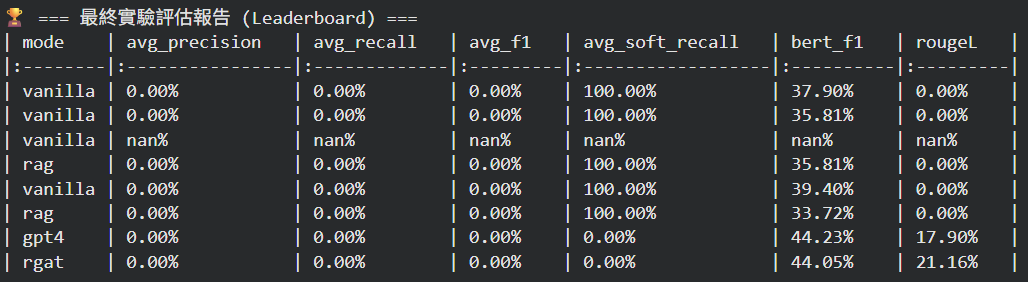